# Disco Diffusion v5.4 - Now with Warp

Disco Diffusion - http://discodiffusion.com/ , https://github.com/alembics/disco-diffusion

In case of confusion, Disco is the name of this notebook edit. The diffusion model in use is Katherine Crowson's fine-tuned 512x512 model

For issues, join the [Disco Diffusion Discord](https://discord.gg/msEZBy4HxA) or message us on twitter at [@somnai_dreams](https://twitter.com/somnai_dreams) or [@gandamu](https://twitter.com/gandamu_ml)

# Tutorial

**Diffusion settings (Defaults are heavily outdated)**
---
Disco Diffusion is complex, and continually evolving with new features.  The most current documentation on on Disco Diffusion settings can be found in the unofficial guidebook:

[Zippy's Disco Diffusion Cheatsheet](https://docs.google.com/document/d/1l8s7uS2dGqjztYSjPpzlmXLjl5PM3IGkRWI3IiCuK7g/edit)

We also encourage users to join the [Disco Diffusion User Discord](https://discord.gg/XGZrFFCRfN) to learn from the active user community.

# 1. Set Up

In [17]:
# @title 1.1 Check GPU Status
import subprocess

simple_nvidia_smi_display = False  # @param {type:"boolean"}
if simple_nvidia_smi_display:
    #!nvidia-smi
    nvidiasmi_output = subprocess.run(
        ["nvidia-smi", "-L"], stdout=subprocess.PIPE
    ).stdout.decode("utf-8")
    print(nvidiasmi_output)
else:
    #!nvidia-smi -i 0 -e 0
    nvidiasmi_output = subprocess.run(
        ["nvidia-smi"], stdout=subprocess.PIPE
    ).stdout.decode("utf-8")
    print(nvidiasmi_output)
    nvidiasmi_ecc_note = subprocess.run(
        ["nvidia-smi", "-i", "0", "-e", "0"], stdout=subprocess.PIPE
    ).stdout.decode("utf-8")
    print(nvidiasmi_ecc_note)

Tue Jun 21 07:08:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:0F:00.0 Off |                    0 |
| N/A   34C    P0    58W / 400W |   5204MiB / 40537MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:47:00.0 Off |                    0 |
| N/A   

In [18]:
# @title 1.2 Prepare Folders
import subprocess, os, sys, ipykernel


def gitclone(url, targetdir=None):
    if targetdir:
        res = subprocess.run(
            ["git", "clone", url, targetdir], stdout=subprocess.PIPE
        ).stdout.decode("utf-8")
    else:
        res = subprocess.run(
            ["git", "clone", url], stdout=subprocess.PIPE
        ).stdout.decode("utf-8")
    print(res)


def pipi(modulestr):
    res = subprocess.run(
        ["pip", "install", modulestr], stdout=subprocess.PIPE
    ).stdout.decode("utf-8")
    print(res)


def pipie(modulestr):
    res = subprocess.run(
        ["git", "install", "-e", modulestr], stdout=subprocess.PIPE
    ).stdout.decode("utf-8")
    print(res)


def wget(url, outputdir):
    res = subprocess.run(
        ["wget", url, "-P", f"{outputdir}"], stdout=subprocess.PIPE
    ).stdout.decode("utf-8")
    print(res)


root_path = "/workspace/projects/disco-imagen"

import os


def createPath(filepath):
    os.makedirs(filepath, exist_ok=True)


initDirPath = f"{root_path}/init_images"
createPath(initDirPath)
outDirPath = f"{root_path}/images_out"
createPath(outDirPath)

model_path = f"{root_path}/models"

# libraries = f'{root_path}/libraries'
# createPath(libraries)

In [19]:
# @title ### 1.3 Install, import dependencies and set up runtime devices

import pathlib, shutil, os, sys

# @markdown Check this if you want to use CPU
useCPU = False  # @param {type:"boolean"}

# If running locally, there's a good chance your env will need this in order to not crash upon np.matmul() or similar operations.
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

PROJECT_DIR = root_path
USE_ADABINS = True

os.chdir(f"{PROJECT_DIR}")
model_path = f"{root_path}/models"

sys.path.append(f"{PROJECT_DIR}/CLIP")
sys.path.append(f"{PROJECT_DIR}/guided-diffusion")
sys.path.append(f"{PROJECT_DIR}/ResizeRight")
sys.path.append(f"{PROJECT_DIR}/pytorch3d-lite")

if not os.path.exists("MiDaS/midas_utils.py"):
    shutil.move("MiDaS/utils.py", "MiDaS/midas_utils.py")
if not os.path.exists(f"{model_path}/dpt_large-midas-2f21e586.pt"):
    wget(
        "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt",
        model_path,
    )
sys.path.append(f"{PROJECT_DIR}/MiDaS")

if not os.path.exists("disco_xform_utils.py"):
    shutil.move("disco-diffusion/disco_xform_utils.py", "disco_xform_utils.py")
sys.path.append(PROJECT_DIR)

import torch
from dataclasses import dataclass
from functools import partial
import cv2
import pandas as pd
import gc
import io
import math
import timm
from IPython import display
import lpips
from PIL import Image, ImageOps
import requests
from glob import glob
import json
from types import SimpleNamespace
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm.notebook import tqdm
from CLIP import clip
from resize_right import resize
from guided_diffusion.script_util import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
)
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import random
from ipywidgets import Output
import hashlib
from functools import partial

from IPython.display import Image as ipyimg
from numpy import asarray
from einops import rearrange, repeat
import torch, torchvision
import time
from omegaconf import OmegaConf
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# AdaBins stuff
if USE_ADABINS:
    if not os.path.exists(f"{PROJECT_DIR}/pretrained/AdaBins_nyu.pt"):
        createPath(f"{PROJECT_DIR}/pretrained")
        wget(
            "https://cloudflare-ipfs.com/ipfs/Qmd2mMnDLWePKmgfS8m6ntAg4nhV5VkUyAydYBp8cWWeB7/AdaBins_nyu.pt",
            f"{PROJECT_DIR}/pretrained",
        )
    sys.path.append(f"{PROJECT_DIR}/AdaBins")
    from infer import InferenceHelper

    MAX_ADABINS_AREA = 500000

import torch

DEVICE = torch.device("cuda:0" if (torch.cuda.is_available() and not useCPU) else "cpu")
print("Using device:", DEVICE)
device = DEVICE  # At least one of the modules expects this name..

if not useCPU:
    if torch.cuda.get_device_capability(DEVICE) == (8, 0):  ## A100 fix thanks to Emad
        print("Disabling CUDNN for A100 gpu", file=sys.stderr)
        torch.backends.cudnn.enabled = False

Using device: cuda:0


Disabling CUDNN for A100 gpu


In [20]:
# @title ### 1.4 Define Midas functions

from midas.dpt_depth import DPTDepthModel
from midas.midas_net import MidasNet
from midas.midas_net_custom import MidasNet_small
from midas.transforms import Resize, NormalizeImage, PrepareForNet

# Initialize MiDaS depth model.
# It remains resident in VRAM and likely takes around 2GB VRAM.
# You could instead initialize it for each frame (and free it after each frame) to save VRAM.. but initializing it is slow.
default_models = {
    "midas_v21_small": f"{model_path}/midas_v21_small-70d6b9c8.pt",
    "midas_v21": f"{model_path}/midas_v21-f6b98070.pt",
    "dpt_large": f"{model_path}/dpt_large-midas-2f21e586.pt",
    "dpt_hybrid": f"{model_path}/dpt_hybrid-midas-501f0c75.pt",
    "dpt_hybrid_nyu": f"{model_path}/dpt_hybrid_nyu-2ce69ec7.pt",
}


def init_midas_depth_model(midas_model_type="dpt_large", optimize=True):
    midas_model = None
    net_w = None
    net_h = None
    resize_mode = None
    normalization = None

    print(f"Initializing MiDaS '{midas_model_type}' depth model...")
    # load network
    midas_model_path = default_models[midas_model_type]

    if midas_model_type == "dpt_large":  # DPT-Large
        midas_model = DPTDepthModel(
            path=midas_model_path,
            backbone="vitl16_384",
            non_negative=True,
        )
        net_w, net_h = 384, 384
        resize_mode = "minimal"
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    elif midas_model_type == "dpt_hybrid":  # DPT-Hybrid
        midas_model = DPTDepthModel(
            path=midas_model_path,
            backbone="vitb_rn50_384",
            non_negative=True,
        )
        net_w, net_h = 384, 384
        resize_mode = "minimal"
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    elif midas_model_type == "dpt_hybrid_nyu":  # DPT-Hybrid-NYU
        midas_model = DPTDepthModel(
            path=midas_model_path,
            backbone="vitb_rn50_384",
            non_negative=True,
        )
        net_w, net_h = 384, 384
        resize_mode = "minimal"
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    elif midas_model_type == "midas_v21":
        midas_model = MidasNet(midas_model_path, non_negative=True)
        net_w, net_h = 384, 384
        resize_mode = "upper_bound"
        normalization = NormalizeImage(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    elif midas_model_type == "midas_v21_small":
        midas_model = MidasNet_small(
            midas_model_path,
            features=64,
            backbone="efficientnet_lite3",
            exportable=True,
            non_negative=True,
            blocks={"expand": True},
        )
        net_w, net_h = 256, 256
        resize_mode = "upper_bound"
        normalization = NormalizeImage(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
    else:
        print(f"midas_model_type '{midas_model_type}' not implemented")
        assert False

    midas_transform = T.Compose(
        [
            Resize(
                net_w,
                net_h,
                resize_target=None,
                keep_aspect_ratio=True,
                ensure_multiple_of=32,
                resize_method=resize_mode,
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            normalization,
            PrepareForNet(),
        ]
    )

    midas_model.eval()

    if optimize == True:
        if DEVICE == torch.device("cuda"):
            midas_model = midas_model.to(memory_format=torch.channels_last)
            midas_model = midas_model.half()

    midas_model.to(DEVICE)

    print(f"MiDaS '{midas_model_type}' depth model initialized.")
    return midas_model, midas_transform, net_w, net_h, resize_mode, normalization

In [21]:
# @title 1.5 Define necessary functions

# https://gist.github.com/adefossez/0646dbe9ed4005480a2407c62aac8869

import py3d_tools as p3dT
import disco_xform_utils as dxf


def interp(t):
    return 3 * t ** 2 - 2 * t ** 3


def perlin(width, height, scale=10, device=None):
    gx, gy = torch.randn(2, width + 1, height + 1, 1, 1, device=device)
    xs = torch.linspace(0, 1, scale + 1)[:-1, None].to(device)
    ys = torch.linspace(0, 1, scale + 1)[None, :-1].to(device)
    wx = 1 - interp(xs)
    wy = 1 - interp(ys)
    dots = 0
    dots += wx * wy * (gx[:-1, :-1] * xs + gy[:-1, :-1] * ys)
    dots += (1 - wx) * wy * (-gx[1:, :-1] * (1 - xs) + gy[1:, :-1] * ys)
    dots += wx * (1 - wy) * (gx[:-1, 1:] * xs - gy[:-1, 1:] * (1 - ys))
    dots += (1 - wx) * (1 - wy) * (-gx[1:, 1:] * (1 - xs) - gy[1:, 1:] * (1 - ys))
    return dots.permute(0, 2, 1, 3).contiguous().view(width * scale, height * scale)


def perlin_ms(octaves, width, height, grayscale, device=device):
    out_array = [0.5] if grayscale else [0.5, 0.5, 0.5]
    # out_array = [0.0] if grayscale else [0.0, 0.0, 0.0]
    for i in range(1 if grayscale else 3):
        scale = 2 ** len(octaves)
        oct_width = width
        oct_height = height
        for oct in octaves:
            p = perlin(oct_width, oct_height, scale, device)
            out_array[i] += p * oct
            scale //= 2
            oct_width *= 2
            oct_height *= 2
    return torch.cat(out_array)


def create_perlin_noise(octaves=[1, 1, 1, 1], width=2, height=2, grayscale=True):
    out = perlin_ms(octaves, width, height, grayscale)
    if grayscale:
        out = TF.resize(size=(side_y, side_x), img=out.unsqueeze(0))
        out = TF.to_pil_image(out.clamp(0, 1)).convert("RGB")
    else:
        out = out.reshape(-1, 3, out.shape[0] // 3, out.shape[1])
        out = TF.resize(size=(side_y, side_x), img=out)
        out = TF.to_pil_image(out.clamp(0, 1).squeeze())

    out = ImageOps.autocontrast(out)
    return out


def regen_perlin():
    if perlin_mode == "color":
        init = create_perlin_noise([1.5 ** -i * 0.5 for i in range(12)], 1, 1, False)
        init2 = create_perlin_noise([1.5 ** -i * 0.5 for i in range(8)], 4, 4, False)
    elif perlin_mode == "gray":
        init = create_perlin_noise([1.5 ** -i * 0.5 for i in range(12)], 1, 1, True)
        init2 = create_perlin_noise([1.5 ** -i * 0.5 for i in range(8)], 4, 4, True)
    else:
        init = create_perlin_noise([1.5 ** -i * 0.5 for i in range(12)], 1, 1, False)
        init2 = create_perlin_noise([1.5 ** -i * 0.5 for i in range(8)], 4, 4, True)

    init = (
        TF.to_tensor(init)
        .add(TF.to_tensor(init2))
        .div(2)
        .to(device)
        .unsqueeze(0)
        .mul(2)
        .sub(1)
    )
    del init2
    return init.expand(batch_size, -1, -1, -1)


def fetch(url_or_path):
    if str(url_or_path).startswith("http://") or str(url_or_path).startswith(
        "https://"
    ):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, "rb")


def read_image_workaround(path):
    """OpenCV reads images as BGR, Pillow saves them as RGB. Work around
    this incompatibility to avoid colour inversions."""
    im_tmp = cv2.imread(path)
    return cv2.cvtColor(im_tmp, cv2.COLOR_BGR2RGB)


def parse_prompt(prompt):
    if prompt.startswith("http://") or prompt.startswith("https://"):
        vals = prompt.rsplit(":", 2)
        vals = [vals[0] + ":" + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(":", 1)
    vals = vals + ["", "1"][len(vals) :]
    return vals[0], float(vals[1])


def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x / a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]


def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.reshape([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), "reflect")
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), "reflect")
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.reshape([n, c, h, w])
    return F.interpolate(input, size, mode="bicubic", align_corners=align_corners)


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, skip_augs=False):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.skip_augs = skip_augs
        self.augs = T.Compose(
            [
                T.RandomHorizontalFlip(p=0.5),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                T.RandomPerspective(distortion_scale=0.4, p=0.7),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                T.RandomGrayscale(p=0.15),
                T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            ]
        )

    def forward(self, input):
        input = T.Pad(input.shape[2] // 4, fill=0)(input)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)

        cutouts = []
        for ch in range(self.cutn):
            if ch > self.cutn - self.cutn // 4:
                cutout = input.clone()
            else:
                size = int(
                    max_size
                    * torch.zeros(
                        1,
                    )
                    .normal_(mean=0.8, std=0.3)
                    .clip(float(self.cut_size / max_size), 1.0)
                )
                offsetx = torch.randint(0, abs(sideX - size + 1), ())
                offsety = torch.randint(0, abs(sideY - size + 1), ())
                cutout = input[:, :, offsety : offsety + size, offsetx : offsetx + size]

            if not self.skip_augs:
                cutout = self.augs(cutout)
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
            del cutout

        cutouts = torch.cat(cutouts, dim=0)
        return cutouts


cutout_debug = False
padargs = {}


class MakeCutoutsDango(nn.Module):
    def __init__(
        self, cut_size, Overview=4, InnerCrop=0, IC_Size_Pow=0.5, IC_Grey_P=0.2
    ):
        super().__init__()
        self.cut_size = cut_size
        self.Overview = Overview
        self.InnerCrop = InnerCrop
        self.IC_Size_Pow = IC_Size_Pow
        self.IC_Grey_P = IC_Grey_P
        if args.animation_mode == "None":
            self.augs = T.Compose(
                [
                    T.RandomHorizontalFlip(p=0.5),
                    T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                    T.RandomAffine(
                        degrees=10,
                        translate=(0.05, 0.05),
                        interpolation=T.InterpolationMode.BILINEAR,
                    ),
                    T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                    T.RandomGrayscale(p=0.1),
                    T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                    T.ColorJitter(
                        brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1
                    ),
                ]
            )
        elif args.animation_mode == "Video Input":
            self.augs = T.Compose(
                [
                    T.RandomHorizontalFlip(p=0.5),
                    T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                    T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
                    T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                    T.RandomPerspective(distortion_scale=0.4, p=0.7),
                    T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                    T.RandomGrayscale(p=0.15),
                    T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                    # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                ]
            )
        elif args.animation_mode == "2D" or args.animation_mode == "3D":
            self.augs = T.Compose(
                [
                    T.RandomHorizontalFlip(p=0.4),
                    T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                    T.RandomAffine(
                        degrees=10,
                        translate=(0.05, 0.05),
                        interpolation=T.InterpolationMode.BILINEAR,
                    ),
                    T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                    T.RandomGrayscale(p=0.1),
                    T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
                    T.ColorJitter(
                        brightness=0.1, contrast=0.1, saturation=0.1, hue=0.3
                    ),
                ]
            )

    def forward(self, input):
        cutouts = []
        gray = T.Grayscale(3)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        l_size = max(sideX, sideY)
        output_shape = [1, 3, self.cut_size, self.cut_size]
        output_shape_2 = [1, 3, self.cut_size + 2, self.cut_size + 2]
        pad_input = F.pad(
            input,
            (
                (sideY - max_size) // 2,
                (sideY - max_size) // 2,
                (sideX - max_size) // 2,
                (sideX - max_size) // 2,
            ),
            **padargs,
        )
        cutout = resize(pad_input, out_shape=output_shape)

        if self.Overview > 0:
            if self.Overview <= 4:
                if self.Overview >= 1:
                    cutouts.append(cutout)
                if self.Overview >= 2:
                    cutouts.append(gray(cutout))
                if self.Overview >= 3:
                    cutouts.append(TF.hflip(cutout))
                if self.Overview == 4:
                    cutouts.append(gray(TF.hflip(cutout)))
            else:
                cutout = resize(pad_input, out_shape=output_shape)
                for _ in range(self.Overview):
                    cutouts.append(cutout)

            if cutout_debug:
                TF.to_pil_image(cutouts[0].clamp(0, 1).squeeze(0)).save(
                    "cutout_overview0.jpg", quality=99
                )

        if self.InnerCrop > 0:
            for i in range(self.InnerCrop):
                size = int(
                    torch.rand([]) ** self.IC_Size_Pow * (max_size - min_size)
                    + min_size
                )
                offsetx = torch.randint(0, sideX - size + 1, ())
                offsety = torch.randint(0, sideY - size + 1, ())
                cutout = input[:, :, offsety : offsety + size, offsetx : offsetx + size]
                if i <= int(self.IC_Grey_P * self.InnerCrop):
                    cutout = gray(cutout)
                cutout = resize(cutout, out_shape=output_shape)
                cutouts.append(cutout)
            if cutout_debug:
                TF.to_pil_image(cutouts[-1].clamp(0, 1).squeeze(0)).save(
                    "cutout_InnerCrop.jpg", quality=99
                )
        cutouts = torch.cat(cutouts)
        if skip_augs is not True:
            cutouts = self.augs(cutouts)
        return cutouts


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), "replicate")
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff ** 2 + y_diff ** 2).mean([1, 2, 3])


def range_loss(input):
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])


stop_on_next_loop = False  # Make sure GPU memory doesn't get corrupted from cancelling the run mid-way through, allow a full frame to complete
TRANSLATION_SCALE = 1.0 / 200.0


def do_3d_step(img_filepath, frame_num, midas_model, midas_transform):
    if args.key_frames:
        translation_x = args.translation_x_series[frame_num]
        translation_y = args.translation_y_series[frame_num]
        translation_z = args.translation_z_series[frame_num]
        rotation_3d_x = args.rotation_3d_x_series[frame_num]
        rotation_3d_y = args.rotation_3d_y_series[frame_num]
        rotation_3d_z = args.rotation_3d_z_series[frame_num]
        print(
            f"translation_x: {translation_x}",
            f"translation_y: {translation_y}",
            f"translation_z: {translation_z}",
            f"rotation_3d_x: {rotation_3d_x}",
            f"rotation_3d_y: {rotation_3d_y}",
            f"rotation_3d_z: {rotation_3d_z}",
        )

    translate_xyz = [
        -translation_x * TRANSLATION_SCALE,
        translation_y * TRANSLATION_SCALE,
        -translation_z * TRANSLATION_SCALE,
    ]
    rotate_xyz_degrees = [rotation_3d_x, rotation_3d_y, rotation_3d_z]
    print("translation:", translate_xyz)
    print("rotation:", rotate_xyz_degrees)
    rotate_xyz = [
        math.radians(rotate_xyz_degrees[0]),
        math.radians(rotate_xyz_degrees[1]),
        math.radians(rotate_xyz_degrees[2]),
    ]
    rot_mat = p3dT.euler_angles_to_matrix(
        torch.tensor(rotate_xyz, device=device), "XYZ"
    ).unsqueeze(0)
    print("rot_mat: " + str(rot_mat))
    next_step_pil = dxf.transform_image_3d(
        img_filepath,
        midas_model,
        midas_transform,
        DEVICE,
        rot_mat,
        translate_xyz,
        args.near_plane,
        args.far_plane,
        args.fov,
        padding_mode=args.padding_mode,
        sampling_mode=args.sampling_mode,
        midas_weight=args.midas_weight,
    )
    return next_step_pil


def symmetry_transformation_fn(x):
    if args.use_horizontal_symmetry:
        [n, c, h, w] = x.size()
        x = torch.concat(
            (x[:, :, :, : w // 2], torch.flip(x[:, :, :, : w // 2], [-1])), -1
        )
        print("horizontal symmetry applied")
    if args.use_vertical_symmetry:
        [n, c, h, w] = x.size()
        x = torch.concat(
            (x[:, :, : h // 2, :], torch.flip(x[:, :, : h // 2, :], [-2])), -2
        )
        print("vertical symmetry applied")
    return x


def do_run():
    seed = args.seed
    print(range(args.start_frame, args.max_frames))

    if (args.animation_mode == "3D") and (args.midas_weight > 0.0):
        (
            midas_model,
            midas_transform,
            midas_net_w,
            midas_net_h,
            midas_resize_mode,
            midas_normalization,
        ) = init_midas_depth_model(args.midas_depth_model)
    for frame_num in range(args.start_frame, args.max_frames):
        if stop_on_next_loop:
            break

        display.clear_output(wait=True)

        # Print Frame progress if animation mode is on
        if args.animation_mode != "None":
            batchBar = tqdm(range(args.max_frames), desc="Frames")
            batchBar.n = frame_num
            batchBar.refresh()

        # Inits if not video frames
        if args.animation_mode != "Video Input":
            if args.init_image in ["", "none", "None", "NONE"]:
                init_image = None
            else:
                init_image = args.init_image
            init_scale = args.init_scale
            skip_steps = args.skip_steps

        if args.animation_mode == "2D":
            if args.key_frames:
                angle = args.angle_series[frame_num]
                zoom = args.zoom_series[frame_num]
                translation_x = args.translation_x_series[frame_num]
                translation_y = args.translation_y_series[frame_num]
                print(
                    f"angle: {angle}",
                    f"zoom: {zoom}",
                    f"translation_x: {translation_x}",
                    f"translation_y: {translation_y}",
                )

            if frame_num > 0:
                seed += 1
                if resume_run and frame_num == start_frame:
                    img_0 = cv2.imread(
                        batchFolder
                        + f"/{batch_name}({batchNum})_{start_frame-1:04}.png"
                    )
                else:
                    img_0 = cv2.imread("prevFrame.png")
                center = (1 * img_0.shape[1] // 2, 1 * img_0.shape[0] // 2)
                trans_mat = np.float32([[1, 0, translation_x], [0, 1, translation_y]])
                rot_mat = cv2.getRotationMatrix2D(center, angle, zoom)
                trans_mat = np.vstack([trans_mat, [0, 0, 1]])
                rot_mat = np.vstack([rot_mat, [0, 0, 1]])
                transformation_matrix = np.matmul(rot_mat, trans_mat)
                img_0 = cv2.warpPerspective(
                    img_0,
                    transformation_matrix,
                    (img_0.shape[1], img_0.shape[0]),
                    borderMode=cv2.BORDER_WRAP,
                )

                cv2.imwrite("prevFrameScaled.png", img_0)
                init_image = "prevFrameScaled.png"
                init_scale = args.frames_scale
                skip_steps = args.calc_frames_skip_steps

        if args.animation_mode == "3D":
            if frame_num > 0:
                seed += 1
                if resume_run and frame_num == start_frame:
                    img_filepath = (
                        batchFolder
                        + f"/{batch_name}({batchNum})_{start_frame-1:04}.png"
                    )
                    if turbo_mode and frame_num > turbo_preroll:
                        shutil.copyfile(img_filepath, "oldFrameScaled.png")
                else:
                    img_filepath = "prevFrame.png"

                next_step_pil = do_3d_step(
                    img_filepath, frame_num, midas_model, midas_transform
                )
                next_step_pil.save("prevFrameScaled.png")

                ### Turbo mode - skip some diffusions, use 3d morph for clarity and to save time
                if turbo_mode:
                    if frame_num == turbo_preroll:  # start tracking oldframe
                        next_step_pil.save(
                            "oldFrameScaled.png"
                        )  # stash for later blending
                    elif frame_num > turbo_preroll:
                        # set up 2 warped image sequences, old & new, to blend toward new diff image
                        old_frame = do_3d_step(
                            "oldFrameScaled.png",
                            frame_num,
                            midas_model,
                            midas_transform,
                        )
                        old_frame.save("oldFrameScaled.png")
                        if frame_num % int(turbo_steps) != 0:
                            print(
                                "turbo skip this frame: skipping clip diffusion steps"
                            )
                            filename = (
                                f"{args.batch_name}({args.batchNum})_{frame_num:04}.png"
                            )
                            blend_factor = ((frame_num % int(turbo_steps)) + 1) / int(
                                turbo_steps
                            )
                            print(
                                "turbo skip this frame: skipping clip diffusion steps and saving blended frame"
                            )
                            newWarpedImg = cv2.imread(
                                "prevFrameScaled.png"
                            )  # this is already updated..
                            oldWarpedImg = cv2.imread("oldFrameScaled.png")
                            blendedImage = cv2.addWeighted(
                                newWarpedImg,
                                blend_factor,
                                oldWarpedImg,
                                1 - blend_factor,
                                0.0,
                            )
                            cv2.imwrite(f"{batchFolder}/{filename}", blendedImage)
                            next_step_pil.save(
                                f"{img_filepath}"
                            )  # save it also as prev_frame to feed next iteration
                            if vr_mode:
                                generate_eye_views(
                                    TRANSLATION_SCALE,
                                    batchFolder,
                                    filename,
                                    frame_num,
                                    midas_model,
                                    midas_transform,
                                )
                            continue
                        else:
                            # if not a skip frame, will run diffusion and need to blend.
                            oldWarpedImg = cv2.imread("prevFrameScaled.png")
                            cv2.imwrite(
                                f"oldFrameScaled.png", oldWarpedImg
                            )  # swap in for blending later
                            print("clip/diff this frame - generate clip diff image")

                init_image = "prevFrameScaled.png"
                init_scale = args.frames_scale
                skip_steps = args.calc_frames_skip_steps

        if args.animation_mode == "Video Input":
            init_scale = args.video_init_frames_scale
            skip_steps = args.calc_frames_skip_steps
            if not video_init_seed_continuity:
                seed += 1
            if video_init_flow_warp:
                if frame_num == 0:
                    skip_steps = args.video_init_skip_steps
                    init_image = f"{videoFramesFolder}/{frame_num+1:04}.jpg"
                if frame_num > 0:
                    prev = PIL.Image.open(
                        batchFolder + f"/{batch_name}({batchNum})_{frame_num-1:04}.png"
                    )

                    frame1_path = f"{videoFramesFolder}/{frame_num:04}.jpg"
                    frame2 = PIL.Image.open(f"{videoFramesFolder}/{frame_num+1:04}.jpg")
                    flo_path = f"/{flo_folder}/{frame1_path.split('/')[-1]}.npy"

                    init_image = "warped.png"
                    print(video_init_flow_blend)
                    weights_path = None
                    if video_init_check_consistency:
                        # TBD
                        pass

                    warp(
                        prev,
                        frame2,
                        flo_path,
                        blend=video_init_flow_blend,
                        weights_path=weights_path,
                    ).save(init_image)

            else:
                init_image = f"{videoFramesFolder}/{frame_num+1:04}.jpg"

        loss_values = []

        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True

        target_embeds, weights = [], []

        if args.prompts_series is not None and frame_num >= len(args.prompts_series):
            frame_prompt = args.prompts_series[-1]
        elif args.prompts_series is not None:
            frame_prompt = args.prompts_series[frame_num]
        else:
            frame_prompt = []

        print(args.image_prompts_series)
        if args.image_prompts_series is not None and frame_num >= len(
            args.image_prompts_series
        ):
            image_prompt = args.image_prompts_series[-1]
        elif args.image_prompts_series is not None:
            image_prompt = args.image_prompts_series[frame_num]
        else:
            image_prompt = []

        print(f"Frame {frame_num} Prompt: {frame_prompt}")

        model_stats = []
        for clip_model in clip_models:
            cutn = 16
            model_stat = {
                "clip_model": None,
                "target_embeds": [],
                "make_cutouts": None,
                "weights": [],
            }
            model_stat["clip_model"] = clip_model

            for prompt in frame_prompt:
                txt, weight = parse_prompt(prompt)
                txt = clip_model.encode_text(clip.tokenize(prompt).to(device)).float()

                if args.fuzzy_prompt:
                    for i in range(25):
                        model_stat["target_embeds"].append(
                            (txt + torch.randn(txt.shape).cuda() * args.rand_mag).clamp(
                                0, 1
                            )
                        )
                        model_stat["weights"].append(weight)
                else:
                    model_stat["target_embeds"].append(txt)
                    model_stat["weights"].append(weight)

            if image_prompt:
                model_stat["make_cutouts"] = MakeCutouts(
                    clip_model.visual.input_resolution, cutn, skip_augs=skip_augs
                )
                for prompt in image_prompt:
                    path, weight = parse_prompt(prompt)
                    img = Image.open(fetch(path)).convert("RGB")
                    img = TF.resize(
                        img, min(side_x, side_y, *img.size), T.InterpolationMode.LANCZOS
                    )
                    batch = model_stat["make_cutouts"](
                        TF.to_tensor(img).to(device).unsqueeze(0).mul(2).sub(1)
                    )
                    embed = clip_model.encode_image(normalize(batch)).float()
                    if fuzzy_prompt:
                        for i in range(25):
                            model_stat["target_embeds"].append(
                                (
                                    embed + torch.randn(embed.shape).cuda() * rand_mag
                                ).clamp(0, 1)
                            )
                            weights.extend([weight / cutn] * cutn)
                    else:
                        model_stat["target_embeds"].append(embed)
                        model_stat["weights"].extend([weight / cutn] * cutn)

            model_stat["target_embeds"] = torch.cat(model_stat["target_embeds"])
            model_stat["weights"] = torch.tensor(model_stat["weights"], device=device)
            if model_stat["weights"].sum().abs() < 1e-3:
                raise RuntimeError("The weights must not sum to 0.")
            model_stat["weights"] /= model_stat["weights"].sum().abs()
            model_stats.append(model_stat)

        init = None
        if init_image is not None:
            init = Image.open(fetch(init_image)).convert("RGB")
            init = init.resize((args.side_x, args.side_y), Image.LANCZOS)
            init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)

        if args.perlin_init:
            if args.perlin_mode == "color":
                init = create_perlin_noise(
                    [1.5 ** -i * 0.5 for i in range(12)], 1, 1, False
                )
                init2 = create_perlin_noise(
                    [1.5 ** -i * 0.5 for i in range(8)], 4, 4, False
                )
            elif args.perlin_mode == "gray":
                init = create_perlin_noise(
                    [1.5 ** -i * 0.5 for i in range(12)], 1, 1, True
                )
                init2 = create_perlin_noise(
                    [1.5 ** -i * 0.5 for i in range(8)], 4, 4, True
                )
            else:
                init = create_perlin_noise(
                    [1.5 ** -i * 0.5 for i in range(12)], 1, 1, False
                )
                init2 = create_perlin_noise(
                    [1.5 ** -i * 0.5 for i in range(8)], 4, 4, True
                )
            # init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device)
            init = (
                TF.to_tensor(init)
                .add(TF.to_tensor(init2))
                .div(2)
                .to(device)
                .unsqueeze(0)
                .mul(2)
                .sub(1)
            )
            del init2

        cur_t = None

        def cond_fn(x, t, y=None):
            with torch.enable_grad():
                x_is_NaN = False
                x = x.detach().requires_grad_()
                n = x.shape[0]
                if use_secondary_model is True:
                    alpha = torch.tensor(
                        diffusion.sqrt_alphas_cumprod[cur_t],
                        device=device,
                        dtype=torch.float32,
                    )
                    sigma = torch.tensor(
                        diffusion.sqrt_one_minus_alphas_cumprod[cur_t],
                        device=device,
                        dtype=torch.float32,
                    )
                    cosine_t = alpha_sigma_to_t(alpha, sigma)
                    out = secondary_model(x, cosine_t[None].repeat([n])).pred
                    fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
                    x_in = out * fac + x * (1 - fac)
                    x_in_grad = torch.zeros_like(x_in)
                else:
                    my_t = torch.ones([n], device=device, dtype=torch.long) * cur_t
                    out = diffusion.p_mean_variance(
                        model, x, my_t, clip_denoised=False, model_kwargs={"y": y}
                    )
                    fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
                    x_in = out["pred_xstart"] * fac + x * (1 - fac)
                    x_in_grad = torch.zeros_like(x_in)
                for model_stat in model_stats:
                    for i in range(args.cutn_batches):
                        t_int = (
                            int(t.item()) + 1
                        )  # errors on last step without +1, need to find source
                        # when using SLIP Base model the dimensions need to be hard coded to avoid AttributeError: 'VisionTransformer' object has no attribute 'input_resolution'
                        try:
                            input_resolution = model_stat[
                                "clip_model"
                            ].visual.input_resolution
                        except:
                            input_resolution = 224

                        cuts = MakeCutoutsDango(
                            input_resolution,
                            Overview=args.cut_overview[1000 - t_int],
                            InnerCrop=args.cut_innercut[1000 - t_int],
                            IC_Size_Pow=args.cut_ic_pow,
                            IC_Grey_P=args.cut_icgray_p[1000 - t_int],
                        )
                        clip_in = normalize(cuts(x_in.add(1).div(2)))
                        image_embeds = (
                            model_stat["clip_model"].encode_image(clip_in).float()
                        )
                        dists = spherical_dist_loss(
                            image_embeds.unsqueeze(1),
                            model_stat["target_embeds"].unsqueeze(0),
                        )
                        dists = dists.view(
                            [
                                args.cut_overview[1000 - t_int]
                                + args.cut_innercut[1000 - t_int],
                                n,
                                -1,
                            ]
                        )
                        losses = dists.mul(model_stat["weights"]).sum(2).mean(0)
                        loss_values.append(
                            losses.sum().item()
                        )  # log loss, probably shouldn't do per cutn_batch
                        x_in_grad += (
                            torch.autograd.grad(
                                losses.sum() * clip_guidance_scale, x_in
                            )[0]
                            / cutn_batches
                        )
                tv_losses = tv_loss(x_in)
                if use_secondary_model is True:
                    range_losses = range_loss(out)
                else:
                    range_losses = range_loss(out["pred_xstart"])
                sat_losses = torch.abs(x_in - x_in.clamp(min=-1, max=1)).mean()
                loss = (
                    tv_losses.sum() * tv_scale
                    + range_losses.sum() * range_scale
                    + sat_losses.sum() * sat_scale
                )
                if init is not None and init_scale:
                    init_losses = lpips_model(x_in, init)
                    loss = loss + init_losses.sum() * init_scale
                x_in_grad += torch.autograd.grad(loss, x_in)[0]
                if torch.isnan(x_in_grad).any() == False:
                    grad = -torch.autograd.grad(x_in, x, x_in_grad)[0]
                else:
                    # print("NaN'd")
                    x_is_NaN = True
                    grad = torch.zeros_like(x)
            if args.clamp_grad and x_is_NaN == False:
                magnitude = grad.square().mean().sqrt()
                return (
                    grad * magnitude.clamp(max=args.clamp_max) / magnitude
                )  # min=-0.02, min=-clamp_max,
            return grad

        if args.diffusion_sampling_mode == "ddim":
            sample_fn = diffusion.ddim_sample_loop_progressive
        else:
            sample_fn = diffusion.plms_sample_loop_progressive

        image_display = Output()
        for i in range(args.n_batches):
            if args.animation_mode == "None":
                display.clear_output(wait=True)
                batchBar = tqdm(range(args.n_batches), desc="Batches")
                batchBar.n = i
                batchBar.refresh()
            print("")
            display.display(image_display)
            gc.collect()
            torch.cuda.empty_cache()
            cur_t = diffusion.num_timesteps - skip_steps - 1
            total_steps = cur_t

            if perlin_init:
                init = regen_perlin()

            if args.diffusion_sampling_mode == "ddim":
                samples = sample_fn(
                    model,
                    (batch_size, 3, args.side_y, args.side_x),
                    clip_denoised=clip_denoised,
                    model_kwargs={},
                    cond_fn=cond_fn,
                    progress=True,
                    skip_timesteps=skip_steps,
                    init_image=init,
                    randomize_class=randomize_class,
                    eta=eta,
                    # transformation_fn=symmetry_transformation_fn,
                    # transformation_percent=args.transformation_percent,
                )
            else:
                samples = sample_fn(
                    model,
                    (batch_size, 3, args.side_y, args.side_x),
                    clip_denoised=clip_denoised,
                    model_kwargs={},
                    cond_fn=cond_fn,
                    progress=True,
                    skip_timesteps=skip_steps,
                    init_image=init,
                    randomize_class=randomize_class,
                    order=2,
                )

            # with run_display:
            # display.clear_output(wait=True)
            for j, sample in enumerate(samples):
                cur_t -= 1
                intermediateStep = False
                if args.steps_per_checkpoint is not None:
                    if j % steps_per_checkpoint == 0 and j > 0:
                        intermediateStep = True
                elif j in args.intermediate_saves:
                    intermediateStep = True
                with image_display:
                    if (
                        j % args.display_rate == 0
                        or cur_t == -1
                        or intermediateStep == True
                    ):
                        for k, image in enumerate(sample["pred_xstart"]):
                            # tqdm.write(f'Batch {i}, step {j}, output {k}:')
                            current_time = datetime.now().strftime("%y%m%d-%H%M%S_%f")
                            percent = math.ceil(j / total_steps * 100)
                            if args.n_batches > 0:
                                # if intermediates are saved to the subfolder, don't append a step or percentage to the name
                                if (
                                    cur_t == -1
                                    and args.intermediates_in_subfolder is True
                                ):
                                    save_num = (
                                        f"{frame_num:04}"
                                        if animation_mode != "None"
                                        else i
                                    )
                                    filename = f"{args.batch_name}({args.batchNum})_{save_num}.png"
                                else:
                                    # If we're working with percentages, append it
                                    if args.steps_per_checkpoint is not None:
                                        filename = f"{args.batch_name}({args.batchNum})_{i:04}-{percent:02}%.png"
                                    # Or else, iIf we're working with specific steps, append those
                                    else:
                                        filename = f"{args.batch_name}({args.batchNum})_{i:04}-{j:03}.png"
                            image = TF.to_pil_image(image.add(1).div(2).clamp(0, 1))
                            if j % args.display_rate == 0 or cur_t == -1:
                                image.save("progress.png")
                                display.clear_output(wait=True)
                                display.display(display.Image("progress.png"))
                            if args.steps_per_checkpoint is not None:
                                if j % args.steps_per_checkpoint == 0 and j > 0:
                                    if args.intermediates_in_subfolder is True:
                                        image.save(f"{partialFolder}/{filename}")
                                    else:
                                        image.save(f"{batchFolder}/{filename}")
                            else:
                                if j in args.intermediate_saves:
                                    if args.intermediates_in_subfolder is True:
                                        image.save(f"{partialFolder}/{filename}")
                                    else:
                                        image.save(f"{batchFolder}/{filename}")
                            if cur_t == -1:
                                if frame_num == 0:
                                    save_settings()
                                if args.animation_mode != "None":
                                    image.save("prevFrame.png")
                                image.save(f"{batchFolder}/{filename}")
                                if args.animation_mode == "3D":
                                    # If turbo, save a blended image
                                    if turbo_mode and frame_num > 0:
                                        # Mix new image with prevFrameScaled
                                        blend_factor = (1) / int(turbo_steps)
                                        newFrame = cv2.imread(
                                            "prevFrame.png"
                                        )  # This is already updated..
                                        prev_frame_warped = cv2.imread(
                                            "prevFrameScaled.png"
                                        )
                                        blendedImage = cv2.addWeighted(
                                            newFrame,
                                            blend_factor,
                                            prev_frame_warped,
                                            (1 - blend_factor),
                                            0.0,
                                        )
                                        cv2.imwrite(
                                            f"{batchFolder}/{filename}", blendedImage
                                        )
                                    else:
                                        image.save(f"{batchFolder}/{filename}")

                                    if vr_mode:
                                        generate_eye_views(
                                            TRANSLATION_SCALE,
                                            batchFolder,
                                            filename,
                                            frame_num,
                                            midas_model,
                                            midas_transform,
                                        )

                                # if frame_num != args.max_frames-1:
                                #   display.clear_output()

            plt.plot(np.array(loss_values), "r")


def generate_eye_views(
    trans_scale, batchFolder, filename, frame_num, midas_model, midas_transform
):
    for i in range(2):
        theta = vr_eye_angle * (math.pi / 180)
        ray_origin = math.cos(theta) * vr_ipd / 2 * (-1.0 if i == 0 else 1.0)
        ray_rotation = theta if i == 0 else -theta
        translate_xyz = [-(ray_origin) * trans_scale, 0, 0]
        rotate_xyz = [0, (ray_rotation), 0]
        rot_mat = p3dT.euler_angles_to_matrix(
            torch.tensor(rotate_xyz, device=device), "XYZ"
        ).unsqueeze(0)
        transformed_image = dxf.transform_image_3d(
            f"{batchFolder}/{filename}",
            midas_model,
            midas_transform,
            DEVICE,
            rot_mat,
            translate_xyz,
            args.near_plane,
            args.far_plane,
            args.fov,
            padding_mode=args.padding_mode,
            sampling_mode=args.sampling_mode,
            midas_weight=args.midas_weight,
            spherical=True,
        )
        eye_file_path = (
            batchFolder + f"/frame_{frame_num:04}" + ("_l" if i == 0 else "_r") + ".png"
        )
        transformed_image.save(eye_file_path)


def save_settings():
    setting_list = {
        "text_prompts": text_prompts,
        "image_prompts": image_prompts,
        "clip_guidance_scale": clip_guidance_scale,
        "tv_scale": tv_scale,
        "range_scale": range_scale,
        "sat_scale": sat_scale,
        # 'cutn': cutn,
        "cutn_batches": cutn_batches,
        "max_frames": max_frames,
        "interp_spline": interp_spline,
        # 'rotation_per_frame': rotation_per_frame,
        "init_image": init_image,
        "init_scale": init_scale,
        "skip_steps": skip_steps,
        # 'zoom_per_frame': zoom_per_frame,
        "frames_scale": frames_scale,
        "frames_skip_steps": frames_skip_steps,
        "perlin_init": perlin_init,
        "perlin_mode": perlin_mode,
        "skip_augs": skip_augs,
        "randomize_class": randomize_class,
        "clip_denoised": clip_denoised,
        "clamp_grad": clamp_grad,
        "clamp_max": clamp_max,
        "seed": seed,
        "fuzzy_prompt": fuzzy_prompt,
        "rand_mag": rand_mag,
        "eta": eta,
        "width": width_height[0],
        "height": width_height[1],
        "diffusion_model": diffusion_model,
        "use_secondary_model": use_secondary_model,
        "steps": steps,
        "diffusion_steps": diffusion_steps,
        "diffusion_sampling_mode": diffusion_sampling_mode,
        "ViTB32": ViTB32,
        "ViTB16": ViTB16,
        "ViTL14": ViTL14,
        "ViTL14_336px": ViTL14_336px,
        "RN101": RN101,
        "RN50": RN50,
        "RN50x4": RN50x4,
        "RN50x16": RN50x16,
        "RN50x64": RN50x64,
        "cut_overview": str(cut_overview),
        "cut_innercut": str(cut_innercut),
        "cut_ic_pow": cut_ic_pow,
        "cut_icgray_p": str(cut_icgray_p),
        "key_frames": key_frames,
        "max_frames": max_frames,
        "angle": angle,
        "zoom": zoom,
        "translation_x": translation_x,
        "translation_y": translation_y,
        "translation_z": translation_z,
        "rotation_3d_x": rotation_3d_x,
        "rotation_3d_y": rotation_3d_y,
        "rotation_3d_z": rotation_3d_z,
        "midas_depth_model": midas_depth_model,
        "midas_weight": midas_weight,
        "near_plane": near_plane,
        "far_plane": far_plane,
        "fov": fov,
        "padding_mode": padding_mode,
        "sampling_mode": sampling_mode,
        "video_init_path": video_init_path,
        "extract_nth_frame": extract_nth_frame,
        "video_init_seed_continuity": video_init_seed_continuity,
        "turbo_mode": turbo_mode,
        "turbo_steps": turbo_steps,
        "turbo_preroll": turbo_preroll,
        "use_horizontal_symmetry": use_horizontal_symmetry,
        "use_vertical_symmetry": use_vertical_symmetry,
        "transformation_percent": transformation_percent,
        # video init settings
        "video_init_steps": video_init_steps,
        "video_init_clip_guidance_scale": video_init_clip_guidance_scale,
        "video_init_tv_scale": video_init_tv_scale,
        "video_init_range_scale": video_init_range_scale,
        "video_init_sat_scale": video_init_sat_scale,
        "video_init_cutn_batches": video_init_cutn_batches,
        "video_init_skip_steps": video_init_skip_steps,
        "video_init_frames_scale": video_init_frames_scale,
        "video_init_frames_skip_steps": video_init_frames_skip_steps,
        # warp settings
        "video_init_flow_warp": video_init_flow_warp,
        "video_init_flow_blend": video_init_flow_blend,
        "video_init_check_consistency": video_init_check_consistency,
        "video_init_blend_mode": video_init_blend_mode,
    }
    # print('Settings:', setting_list)
    with open(
        f"{batchFolder}/{batch_name}({batchNum})_settings.txt", "w+"
    ) as f:  # save settings
        json.dump(setting_list, f, ensure_ascii=False, indent=4)

In [22]:
#@title 1.6 Define the secondary diffusion model

def append_dims(x, n):
    return x[(Ellipsis, *(None,) * (n - x.ndim))]


def expand_to_planes(x, shape):
    return append_dims(x, len(shape)).repeat([1, 1, *shape[2:]])


def alpha_sigma_to_t(alpha, sigma):
    return torch.atan2(sigma, alpha) * 2 / math.pi


def t_to_alpha_sigma(t):
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)


@dataclass
class DiffusionOutput:
    v: torch.Tensor
    pred: torch.Tensor
    eps: torch.Tensor


class ConvBlock(nn.Sequential):
    def __init__(self, c_in, c_out):
        super().__init__(
            nn.Conv2d(c_in, c_out, 3, padding=1),
            nn.ReLU(inplace=True),
        )


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


class SecondaryDiffusionImageNet(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        self.timestep_embed = FourierFeatures(1, 16)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, c),
            ConvBlock(c, c),
            SkipBlock([
                nn.AvgPool2d(2),
                ConvBlock(c, c * 2),
                ConvBlock(c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),
                    ConvBlock(c * 2, c * 4),
                    ConvBlock(c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),
                        ConvBlock(c * 4, c * 8),
                        ConvBlock(c * 8, c * 4),
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                    ]),
                    ConvBlock(c * 8, c * 4),
                    ConvBlock(c * 4, c * 2),
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                ]),
                ConvBlock(c * 4, c * 2),
                ConvBlock(c * 2, c),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ]),
            ConvBlock(c * 2, c),
            nn.Conv2d(c, 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)


class SecondaryDiffusionImageNet2(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count
        cs = [c, c * 2, c * 2, c * 4, c * 4, c * 8]

        self.timestep_embed = FourierFeatures(1, 16)
        self.down = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, cs[0]),
            ConvBlock(cs[0], cs[0]),
            SkipBlock([
                self.down,
                ConvBlock(cs[0], cs[1]),
                ConvBlock(cs[1], cs[1]),
                SkipBlock([
                    self.down,
                    ConvBlock(cs[1], cs[2]),
                    ConvBlock(cs[2], cs[2]),
                    SkipBlock([
                        self.down,
                        ConvBlock(cs[2], cs[3]),
                        ConvBlock(cs[3], cs[3]),
                        SkipBlock([
                            self.down,
                            ConvBlock(cs[3], cs[4]),
                            ConvBlock(cs[4], cs[4]),
                            SkipBlock([
                                self.down,
                                ConvBlock(cs[4], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[4]),
                                self.up,
                            ]),
                            ConvBlock(cs[4] * 2, cs[4]),
                            ConvBlock(cs[4], cs[3]),
                            self.up,
                        ]),
                        ConvBlock(cs[3] * 2, cs[3]),
                        ConvBlock(cs[3], cs[2]),
                        self.up,
                    ]),
                    ConvBlock(cs[2] * 2, cs[2]),
                    ConvBlock(cs[2], cs[1]),
                    self.up,
                ]),
                ConvBlock(cs[1] * 2, cs[1]),
                ConvBlock(cs[1], cs[0]),
                self.up,
            ]),
            ConvBlock(cs[0] * 2, cs[0]),
            nn.Conv2d(cs[0], 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)

# 2. Diffusion and CLIP model settings

In [23]:
#@markdown ####**Models Settings:**
diffusion_model = "512x512_diffusion_uncond_finetune_008100" #@param ["256x256_diffusion_uncond", "512x512_diffusion_uncond_finetune_008100", "custom"]
use_secondary_model = True #@param {type: 'boolean'}
diffusion_sampling_mode = 'ddim' #@param ['plms','ddim']
#@markdown #####**Custom model:**
custom_path = f'{PROJECT_DIR}/models/ddpm/ema_0.9999_058000.pt'#@param {type: 'string'}

#@markdown #####**CLIP settings:**
use_checkpoint = True #@param {type: 'boolean'}
ViTB32 = True #@param{type:"boolean"}
ViTB16 = True #@param{type:"boolean"}
ViTL14 = False #@param{type:"boolean"}
ViTL14_336px = False #@param{type:"boolean"}
RN101 = False #@param{type:"boolean"}
RN50 = True #@param{type:"boolean"}
RN50x4 = False #@param{type:"boolean"}
RN50x16 = False #@param{type:"boolean"}
RN50x64 = False #@param{type:"boolean"}

#@markdown If you're having issues with model downloads, check this to compare SHA's:
check_model_SHA = False #@param{type:"boolean"}

def download_models(diffusion_model,use_secondary_model,fallback=False):
    model_256_downloaded = False
    model_512_downloaded = False
    model_secondary_downloaded = False

    model_256_SHA = '983e3de6f95c88c81b2ca7ebb2c217933be1973b1ff058776b970f901584613a'
    model_512_SHA = '9c111ab89e214862b76e1fa6a1b3f1d329b1a88281885943d2cdbe357ad57648'
    model_secondary_SHA = '983e3de6f95c88c81b2ca7ebb2c217933be1973b1ff058776b970f901584613a'

    model_256_link = 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt'
    model_512_link = 'https://the-eye.eu/public/AI/models/512x512_diffusion_unconditional_ImageNet/512x512_diffusion_uncond_finetune_008100.pt'
    model_secondary_link = 'https://v-diffusion.s3.us-west-2.amazonaws.com/secondary_model_imagenet_2.pth'

    model_256_link_fb = 'https://www.dropbox.com/s/9tqnqo930mpnpcn/256x256_diffusion_uncond.pt'
    model_512_link_fb = 'https://huggingface.co/lowlevelware/512x512_diffusion_unconditional_ImageNet/resolve/main/512x512_diffusion_uncond_finetune_008100.pt'
    model_secondary_link_fb = 'https://the-eye.eu/public/AI/models/v-diffusion/secondary_model_imagenet_2.pth'

    model_256_path = f'{model_path}/256x256_diffusion_uncond.pt'
    model_512_path = f'{model_path}/512x512_diffusion_uncond_finetune_008100.pt'
    model_secondary_path = f'{model_path}/secondary_model_imagenet_2.pth'

    if fallback:
        model_256_link = model_256_link_fb
        model_512_link = model_512_link_fb
        model_secondary_link = model_secondary_link_fb
    # Download the diffusion model
    if diffusion_model == '256x256_diffusion_uncond':
        if os.path.exists(model_256_path) and check_model_SHA:
            print('Checking 256 Diffusion File')
            with open(model_256_path,"rb") as f:
                bytes = f.read() 
                hash = hashlib.sha256(bytes).hexdigest();
            if hash == model_256_SHA:
                print('256 Model SHA matches')
                model_256_downloaded = True
            else:
                print("256 Model SHA doesn't match, redownloading...")
                wget(model_256_link, model_path)
                if os.path.exists(model_256_path):
                    model_256_downloaded = True
                else:
                    print('First URL Failed using FallBack')
                    download_models(diffusion_model,use_secondary_model,True)
        elif os.path.exists(model_256_path) and not check_model_SHA or model_256_downloaded == True:
            print('256 Model already downloaded, check check_model_SHA if the file is corrupt')
        else:  
            wget(model_256_link, model_path)
            if os.path.exists(model_256_path):
                model_256_downloaded = True
            else:
                print('First URL Failed using FallBack')
                download_models(diffusion_model,True)
    elif diffusion_model == '512x512_diffusion_uncond_finetune_008100':
        if os.path.exists(model_512_path) and check_model_SHA:
            print('Checking 512 Diffusion File')
            with open(model_512_path,"rb") as f:
                  bytes = f.read() 
                  hash = hashlib.sha256(bytes).hexdigest();
            if hash == model_512_SHA:
                print('512 Model SHA matches')
                if os.path.exists(model_512_path):
                    model_512_downloaded = True
                else:
                    print('First URL Failed using FallBack')
                    download_models(diffusion_model,use_secondary_model,True)
            else:  
                print("512 Model SHA doesn't match, redownloading...")
                wget(model_512_link, model_path)
                if os.path.exists(model_512_path):
                    model_512_downloaded = True
                else:
                    print('First URL Failed using FallBack')
                    download_models(diffusion_model,use_secondary_model,True)
        elif os.path.exists(model_512_path) and not check_model_SHA or model_512_downloaded:
            print('512 Model already downloaded, check check_model_SHA if the file is corrupt')
        else:  
            wget(model_512_link, model_path)
            model_512_downloaded = True
    # Download the secondary diffusion model v2
    if use_secondary_model:
        if os.path.exists(model_secondary_path) and check_model_SHA:
            print('Checking Secondary Diffusion File')
            with open(model_secondary_path,"rb") as f:
                bytes = f.read() 
                hash = hashlib.sha256(bytes).hexdigest();
            if hash == model_secondary_SHA:
                print('Secondary Model SHA matches')
                model_secondary_downloaded = True
            else:  
                print("Secondary Model SHA doesn't match, redownloading...")
                wget(model_secondary_link, model_path)
                if os.path.exists(model_secondary_path):
                    model_secondary_downloaded = True
                else:
                    print('First URL Failed using FallBack')
                    download_models(diffusion_model,use_secondary_model,True)
        elif os.path.exists(model_secondary_path) and not check_model_SHA or model_secondary_downloaded:
            print('Secondary Model already downloaded, check check_model_SHA if the file is corrupt')
        else:  
            wget(model_secondary_link, model_path)
            if os.path.exists(model_secondary_path):
                model_secondary_downloaded = True
            else:
                print('First URL Failed using FallBack')
                download_models(diffusion_model,use_secondary_model,True)

download_models(diffusion_model,use_secondary_model)

model_config = model_and_diffusion_defaults()
if diffusion_model == '512x512_diffusion_uncond_finetune_008100':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': 1000, #No need to edit this, it is taken care of later.
        'rescale_timesteps': True,
        'timestep_respacing': 250, #No need to edit this, it is taken care of later.
        'image_size': 512,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': not useCPU,
        'use_scale_shift_norm': True,
    })
elif diffusion_model == '256x256_diffusion_uncond':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': 1000, #No need to edit this, it is taken care of later.
        'rescale_timesteps': True,
        'timestep_respacing': 250, #No need to edit this, it is taken care of later.
        'image_size': 256,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': not useCPU,
        'use_scale_shift_norm': True,
    })

model_default = model_config['image_size']

if use_secondary_model:
    secondary_model = SecondaryDiffusionImageNet2()
    secondary_model.load_state_dict(torch.load(f'{model_path}/secondary_model_imagenet_2.pth', map_location='cpu'))
    secondary_model.eval().requires_grad_(False).to(device)

clip_models = []
if ViTB32: clip_models.append(clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device))
if ViTB16: clip_models.append(clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device))
if ViTL14: clip_models.append(clip.load('ViT-L/14', jit=False)[0].eval().requires_grad_(False).to(device))
if ViTL14_336px: clip_models.append(clip.load('ViT-L/14@336px', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50: clip_models.append(clip.load('RN50', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x4: clip_models.append(clip.load('RN50x4', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x16: clip_models.append(clip.load('RN50x16', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x64: clip_models.append(clip.load('RN50x64', jit=False)[0].eval().requires_grad_(False).to(device))
if RN101: clip_models.append(clip.load('RN101', jit=False)[0].eval().requires_grad_(False).to(device))

normalize = T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
lpips_model = lpips.LPIPS(net='vgg').to(device)

512 Model already downloaded, check check_model_SHA if the file is corrupt
Secondary Model already downloaded, check check_model_SHA if the file is corrupt
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


# Custom model settings 
Modify in accordance with your training settings and run the cell

In [24]:
# @markdown ####**Custom Model Settings:**
if diffusion_model == "custom":
    model_config.update(
        {
            "attention_resolutions": "16",
            "class_cond": False,
            "diffusion_steps": 1000,
            "rescale_timesteps": True,
            "timestep_respacing": "ddim100",
            "image_size": 256,
            "learn_sigma": True,
            "noise_schedule": "linear",
            "num_channels": 128,
            "num_heads": 1,
            "num_res_blocks": 2,
            "use_checkpoint": use_checkpoint,
            "use_fp16": True,
            "use_scale_shift_norm": False,
        }
    )


# 3. Settings

In [25]:
# @markdown ####**Basic Settings:**
batch_name = "DiscoMP"  # @param{type: 'string'}
steps = 250  # @param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
width_height = [1280, 768]  # @param{type: 'raw'}
clip_guidance_scale = 5000  # @param{type: 'number'}
tv_scale = 0  # @param{type: 'number'}
range_scale = 150  # @param{type: 'number'}
sat_scale = 0  # @param{type: 'number'}
cutn_batches = 4  # @param{type: 'number'}
skip_augs = False  # @param{type: 'boolean'}

# @markdown ####**Video Init Basic Settings:**
video_init_steps = (
    100  # @param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
)
video_init_clip_guidance_scale = 1000  # @param{type: 'number'}
video_init_tv_scale = 0.1  # @param{type: 'number'}
video_init_range_scale = 150  # @param{type: 'number'}
video_init_sat_scale = 300  # @param{type: 'number'}
video_init_cutn_batches = 4  # @param{type: 'number'}
video_init_skip_steps = 50  # @param{type: 'integer'}

# @markdown ---

# @markdown ####**Init Image Settings:**
init_image = None  # @param{type: 'string'}
init_scale = 1000  # @param{type: 'integer'}
skip_steps = 10  # @param{type: 'integer'}
# @markdown *Make sure you set skip_steps to ~50% of your steps if you want to use an init image.*

# Get corrected sizes
side_x = (width_height[0] // 64) * 64
side_y = (width_height[1] // 64) * 64
if side_x != width_height[0] or side_y != width_height[1]:
    print(
        f"Changing output size to {side_x}x{side_y}. Dimensions must by multiples of 64."
    )

# Make folder for batch
batchFolder = f"{outDirPath}/{batch_name}"
createPath(batchFolder)

### Animation Settings

In [26]:
# @markdown ####**Animation Mode:**
animation_mode = "3D"  # @param ['None', '2D', '3D', 'Video Input'] {type:'string'}
# @markdown *For animation, you probably want to turn `cutn_batches` to 1 to make it quicker.*


# @markdown ---

# @markdown ####**Video Input Settings:**
video_init_path = "init.mp4"  # @param {type: 'string'}
extract_nth_frame = 2  # @param {type: 'number'}
persistent_frame_output_in_batch_folder = True  # @param {type: 'boolean'}
video_init_seed_continuity = False  # @param {type: 'boolean'}
# @markdown #####**Video Optical Flow Settings:**
video_init_flow_warp = True  # @param {type: 'boolean'}
# Call optical flow from video frames and warp prev frame with flow
video_init_flow_blend = (
    0.999  # @param {type: 'number'} #0 - take next frame, 1 - take prev warped frame
)
video_init_check_consistency = False  # Insert param here when ready
video_init_blend_mode = "optical flow"  # @param ['None', 'linear', 'optical flow']
# Call optical flow from video frames and warp prev frame with flow
if animation_mode == "Video Input":
    videoFramesFolder = f"{batchFolder}/videoFrames"
    createPath(videoFramesFolder)
    print(f"Exporting Video Frames (1 every {extract_nth_frame})...")
    try:
        for f in pathlib.Path(f"{videoFramesFolder}").glob("*.jpg"):
            f.unlink()
    except:
        print("")
    vf = f"select=not(mod(n\,{extract_nth_frame}))"
    if os.path.exists(video_init_path):
        subprocess.run(
            [
                "ffmpeg",
                "-i",
                f"{video_init_path}",
                "-vf",
                f"{vf}",
                "-vsync",
                "vfr",
                "-q:v",
                "2",
                "-loglevel",
                "error",
                "-stats",
                f"{videoFramesFolder}/%04d.jpg",
            ],
            stdout=subprocess.PIPE,
        ).stdout.decode("utf-8")
    else:
        print(
            f"\nWARNING!\n\nVideo not found: {video_init_path}.\nPlease check your video path.\n"
        )
    #!ffmpeg -i {video_init_path} -vf {vf} -vsync vfr -q:v 2 -loglevel error -stats {videoFramesFolder}/%04d.jpg


# @markdown ---

# @markdown ####**2D Animation Settings:**
# @markdown `zoom` is a multiplier of dimensions, 1 is no zoom.
# @markdown All rotations are provided in degrees.

key_frames = True  # @param {type:"boolean"}
max_frames = 10000  # @param {type:"number"}

if animation_mode == "Video Input":
    max_frames = len(glob(f"{videoFramesFolder}/*.jpg"))

interp_spline = "Linear"  # Do not change, currently will not look good. param ['Linear','Quadratic','Cubic']{type:"string"}
angle = "0:(0)"  # @param {type:"string"}
zoom = "0: (1), 10: (1.05)"  # @param {type:"string"}
translation_x = "0: (0)"  # @param {type:"string"}
translation_y = "0: (0)"  # @param {type:"string"}
translation_z = "0: (10.0)"  # @param {type:"string"}
rotation_3d_x = "0: (0)"  # @param {type:"string"}
rotation_3d_y = "0: (0)"  # @param {type:"string"}
rotation_3d_z = "0: (0)"  # @param {type:"string"}
midas_depth_model = "dpt_large"  # @param {type:"string"}
midas_weight = 0.3  # @param {type:"number"}
near_plane = 200  # @param {type:"number"}
far_plane = 10000  # @param {type:"number"}
fov = 40  # @param {type:"number"}
padding_mode = "border"  # @param {type:"string"}
sampling_mode = "bicubic"  # @param {type:"string"}

# ======= TURBO MODE
# @markdown ---
# @markdown ####**Turbo Mode (3D anim only):**
# @markdown (Starts after frame 10,) skips diffusion steps and just uses depth map to warp images for skipped frames.
# @markdown Speeds up rendering by 2x-4x, and may improve image coherence between frames.
# @markdown For different settings tuned for Turbo Mode, refer to the original Disco-Turbo Github: https://github.com/zippy731/disco-diffusion-turbo

turbo_mode = False  # @param {type:"boolean"}
turbo_steps = "3"  # @param ["2","3","4","5","6"] {type:"string"}
turbo_preroll = 10  # frames

# insist turbo be used only w 3d anim.
if turbo_mode and animation_mode != "3D":
    print("=====")
    print("Turbo mode only available with 3D animations. Disabling Turbo.")
    print("=====")
    turbo_mode = False

# @markdown ---

# @markdown ####**Coherency Settings:**
# @markdown `frame_scale` tries to guide the new frame to looking like the old one. A good default is 1500.
frames_scale = 1500  # @param{type: 'integer'}
# @markdown `frame_skip_steps` will blur the previous frame - higher values will flicker less but struggle to add enough new detail to zoom into.
frames_skip_steps = "60%"  # @param ['40%', '50%', '60%', '70%', '80%'] {type: 'string'}

# @markdown ####**Video Init Coherency Settings:**
# @markdown `frame_scale` tries to guide the new frame to looking like the old one. A good default is 1500.
video_init_frames_scale = 15000  # @param{type: 'integer'}
# @markdown `frame_skip_steps` will blur the previous frame - higher values will flicker less but struggle to add enough new detail to zoom into.
video_init_frames_skip_steps = (
    "70%"  # @param ['40%', '50%', '60%', '70%', '80%'] {type: 'string'}
)

# ======= VR MODE
# @markdown ---
# @markdown ####**VR Mode (3D anim only):**
# @markdown Enables stereo rendering of left/right eye views (supporting Turbo) which use a different (fish-eye) camera projection matrix.
# @markdown Note the images you're prompting will work better if they have some inherent wide-angle aspect
# @markdown The generated images will need to be combined into left/right videos. These can then be stitched into the VR180 format.
# @markdown Google made the VR180 Creator tool but subsequently stopped supporting it. It's available for download in a few places including https://www.patrickgrunwald.de/vr180-creator-download
# @markdown The tool is not only good for stitching (videos and photos) but also for adding the correct metadata into existing videos, which is needed for services like YouTube to identify the format correctly.
# @markdown Watching YouTube VR videos isn't necessarily the easiest depending on your headset. For instance Oculus have a dedicated media studio and store which makes the files easier to access on a Quest https://creator.oculus.com/manage/mediastudio/
# @markdown
# @markdown The command to get ffmpeg to concat your frames for each eye is in the form: `ffmpeg -framerate 15 -i frame_%4d_l.png l.mp4` (repeat for r)

vr_mode = False  # @param {type:"boolean"}
# @markdown `vr_eye_angle` is the y-axis rotation of the eyes towards the center
vr_eye_angle = 0.5  # @param{type:"number"}
# @markdown interpupillary distance (between the eyes)
vr_ipd = 5.0  # @param{type:"number"}

# insist VR be used only w 3d anim.
if vr_mode and animation_mode != "3D":
    print("=====")
    print("VR mode only available with 3D animations. Disabling VR.")
    print("=====")
    vr_mode = False


def parse_key_frames(string, prompt_parser=None):
    """Given a string representing frame numbers paired with parameter values at that frame,
    return a dictionary with the frame numbers as keys and the parameter values as the values.

    Parameters
    ----------
    string: string
        Frame numbers paired with parameter values at that frame number, in the format
        'framenumber1: (parametervalues1), framenumber2: (parametervalues2), ...'
    prompt_parser: function or None, optional
        If provided, prompt_parser will be applied to each string of parameter values.

    Returns
    -------
    dict
        Frame numbers as keys, parameter values at that frame number as values

    Raises
    ------
    RuntimeError
        If the input string does not match the expected format.

    Examples
    --------
    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)")
    {10: 'Apple: 1| Orange: 0', 20: 'Apple: 0| Orange: 1| Peach: 1'}

    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)", prompt_parser=lambda x: x.lower()))
    {10: 'apple: 1| orange: 0', 20: 'apple: 0| orange: 1| peach: 1'}
    """
    import re

    pattern = r"((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])"
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()["frame"])
        param = match_object.groupdict()["param"]
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param

    if frames == {} and len(string) != 0:
        raise RuntimeError("Key Frame string not correctly formatted")
    return frames


def get_inbetweens(key_frames, integer=False):
    """Given a dict with frame numbers as keys and a parameter value as values,
    return a pandas Series containing the value of the parameter at every frame from 0 to max_frames.
    Any values not provided in the input dict are calculated by linear interpolation between
    the values of the previous and next provided frames. If there is no previous provided frame, then
    the value is equal to the value of the next provided frame, or if there is no next provided frame,
    then the value is equal to the value of the previous provided frame. If no frames are provided,
    all frame values are NaN.

    Parameters
    ----------
    key_frames: dict
        A dict with integer frame numbers as keys and numerical values of a particular parameter as values.
    integer: Bool, optional
        If True, the values of the output series are converted to integers.
        Otherwise, the values are floats.

    Returns
    -------
    pd.Series
        A Series with length max_frames representing the parameter values for each frame.

    Examples
    --------
    >>> max_frames = 5
    >>> get_inbetweens({1: 5, 3: 6})
    0    5.0
    1    5.0
    2    5.5
    3    6.0
    4    6.0
    dtype: float64

    >>> get_inbetweens({1: 5, 3: 6}, integer=True)
    0    5
    1    5
    2    5
    3    6
    4    6
    dtype: int64
    """
    key_frame_series = pd.Series([np.nan for a in range(max_frames)])

    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)

    interp_method = interp_spline

    if interp_method == "Cubic" and len(key_frames.items()) <= 3:
        interp_method = "Quadratic"

    if interp_method == "Quadratic" and len(key_frames.items()) <= 2:
        interp_method = "Linear"

    key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
    key_frame_series[max_frames - 1] = key_frame_series[
        key_frame_series.last_valid_index()
    ]
    # key_frame_series = key_frame_series.interpolate(method=intrp_method,order=1, limit_direction='both')
    key_frame_series = key_frame_series.interpolate(
        method=interp_method.lower(), limit_direction="both"
    )
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series


def split_prompts(prompts):
    prompt_series = pd.Series([np.nan for a in range(max_frames)])
    for i, prompt in prompts.items():
        prompt_series[i] = prompt
    # prompt_series = prompt_series.astype(str)
    prompt_series = prompt_series.ffill().bfill()
    return prompt_series


if key_frames:
    try:
        angle_series = get_inbetweens(parse_key_frames(angle))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `angle` correctly for key frames.\n"
            "Attempting to interpret `angle` as "
            f'"0: ({angle})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        angle = f"0: ({angle})"
        angle_series = get_inbetweens(parse_key_frames(angle))

    try:
        zoom_series = get_inbetweens(parse_key_frames(zoom))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `zoom` correctly for key frames.\n"
            "Attempting to interpret `zoom` as "
            f'"0: ({zoom})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        zoom = f"0: ({zoom})"
        zoom_series = get_inbetweens(parse_key_frames(zoom))

    try:
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_x` correctly for key frames.\n"
            "Attempting to interpret `translation_x` as "
            f'"0: ({translation_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_x = f"0: ({translation_x})"
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))

    try:
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_y` correctly for key frames.\n"
            "Attempting to interpret `translation_y` as "
            f'"0: ({translation_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_y = f"0: ({translation_y})"
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))

    try:
        translation_z_series = get_inbetweens(parse_key_frames(translation_z))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_z` correctly for key frames.\n"
            "Attempting to interpret `translation_z` as "
            f'"0: ({translation_z})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_z = f"0: ({translation_z})"
        translation_z_series = get_inbetweens(parse_key_frames(translation_z))

    try:
        rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_x` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_x` as "
            f'"0: ({rotation_3d_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_x = f"0: ({rotation_3d_x})"
        rotation_3d_x_series = get_inbetweens(parse_key_frames(rotation_3d_x))

    try:
        rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_y` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_y` as "
            f'"0: ({rotation_3d_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_y = f"0: ({rotation_3d_y})"
        rotation_3d_y_series = get_inbetweens(parse_key_frames(rotation_3d_y))

    try:
        rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `rotation_3d_z` correctly for key frames.\n"
            "Attempting to interpret `rotation_3d_z` as "
            f'"0: ({rotation_3d_z})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        rotation_3d_z = f"0: ({rotation_3d_z})"
        rotation_3d_z_series = get_inbetweens(parse_key_frames(rotation_3d_z))

else:
    angle = float(angle)
    zoom = float(zoom)
    translation_x = float(translation_x)
    translation_y = float(translation_y)
    translation_z = float(translation_z)
    rotation_3d_x = float(rotation_3d_x)
    rotation_3d_y = float(rotation_3d_y)
    rotation_3d_z = float(rotation_3d_z)

In [27]:
# @title Install RAFT for Video input animation mode only
# @markdown Run once per session. Doesn't download again if model path exists.
# @markdown Use force download to reload raft models if needed
force_download = False  # @param {type:'boolean'}
if animation_mode == "Video Input":
    try:
        from raft import RAFT
    except:
        if not os.path.exists(os.path.join(PROJECT_DIR, "RAFT")):
            gitclone(
                "https://github.com/princeton-vl/RAFT",
                os.path.join(PROJECT_DIR, "RAFT"),
            )
        sys.path.append(f"{PROJECT_DIR}/RAFT")

    if (not (os.path.exists(f"{root_path}/RAFT/models"))) or force_download:
        createPath(f"{root_path}/RAFT")
        os.chdir(f"{root_path}/RAFT")
        sub_p_res = subprocess.run(
            ["bash", f"{PROJECT_DIR}/RAFT/download_models.sh"], stdout=subprocess.PIPE
        ).stdout.decode("utf-8")
        print(sub_p_res)
        os.chdir(PROJECT_DIR)

In [28]:
# @title Define optical flow functions for Video input animation mode only
if animation_mode == "Video Input":
    in_path = videoFramesFolder
    flo_folder = f"{in_path}/out_flo_fwd"
    path = f"{PROJECT_DIR}/RAFT/core"
    import sys

    sys.path.append(f"{PROJECT_DIR}/RAFT/core")
    os.chdir(f"{PROJECT_DIR}/RAFT/core")
    print(os.getcwd())

    print(
        "Renaming RAFT core's utils.utils to raftutils.utils (to avoid a naming conflict with AdaBins)"
    )
    if not os.path.exists(f"{PROJECT_DIR}/RAFT/core/raftutils"):
        os.rename(
            f"{PROJECT_DIR}/RAFT/core/utils", f"{PROJECT_DIR}/RAFT/core/raftutils"
        )
        sub_p_res = subprocess.run(
            [
                "sed",
                "-i",
                "s/from utils.utils/from raftutils.utils/g",
                f"{PROJECT_DIR}/RAFT/core/corr.py",
            ],
            stdout=subprocess.PIPE,
        ).stdout.decode("utf-8")
        sub_p_res = subprocess.run(
            [
                "sed",
                "-i",
                "s/from utils.utils/from raftutils.utils/g",
                f"{PROJECT_DIR}/RAFT/core/raft.py",
            ],
            stdout=subprocess.PIPE,
        ).stdout.decode("utf-8")

    from raftutils.utils import InputPadder
    from raft import RAFT
    from raftutils import flow_viz
    import numpy as np
    import argparse, PIL, cv2
    from PIL import Image
    from tqdm.notebook import tqdm
    from glob import glob
    import torch

    args2 = argparse.Namespace()
    args2.small = False
    args2.mixed_precision = True

    TAG_CHAR = np.array([202021.25], np.float32)

    def writeFlow(filename, uv, v=None):
        """
        https://github.com/NVIDIA/flownet2-pytorch/blob/master/utils/flow_utils.py
        Copyright 2017 NVIDIA CORPORATION

        Licensed under the Apache License, Version 2.0 (the "License");
        you may not use this file except in compliance with the License.
        You may obtain a copy of the License at

            http://www.apache.org/licenses/LICENSE-2.0

        Unless required by applicable law or agreed to in writing, software
        distributed under the License is distributed on an "AS IS" BASIS,
        WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
        See the License for the specific language governing permissions and
        limitations under the License.

        Write optical flow to file.

        If v is None, uv is assumed to contain both u and v channels,
        stacked in depth.
        Original code by Deqing Sun, adapted from Daniel Scharstein.
        """
        nBands = 2

        if v is None:
            assert uv.ndim == 3
            assert uv.shape[2] == 2
            u = uv[:, :, 0]
            v = uv[:, :, 1]
        else:
            u = uv

        assert u.shape == v.shape
        height, width = u.shape
        f = open(filename, "wb")
        # write the header
        f.write(TAG_CHAR)
        np.array(width).astype(np.int32).tofile(f)
        np.array(height).astype(np.int32).tofile(f)
        # arrange into matrix form
        tmp = np.zeros((height, width * nBands))
        tmp[:, np.arange(width) * 2] = u
        tmp[:, np.arange(width) * 2 + 1] = v
        tmp.astype(np.float32).tofile(f)
        f.close()

    def load_img(img, size):
        img = Image.open(img).convert("RGB").resize(size)
        return (
            torch.from_numpy(np.array(img)).permute(2, 0, 1).float()[None, ...].cuda()
        )

    def get_flow(frame1, frame2, model, iters=20):
        padder = InputPadder(frame1.shape)
        frame1, frame2 = padder.pad(frame1, frame2)
        _, flow12 = model(frame1, frame2, iters=iters, test_mode=True)
        flow12 = flow12[0].permute(1, 2, 0).detach().cpu().numpy()

        return flow12

    def warp_flow(img, flow):
        h, w = flow.shape[:2]
        flow = flow.copy()
        flow[:, :, 0] += np.arange(w)
        flow[:, :, 1] += np.arange(h)[:, np.newaxis]
        res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
        return res

    def makeEven(_x):
        return _x if (_x % 2 == 0) else _x + 1

    def fit(img, maxsize=512):
        maxdim = max(*img.size)
        if maxdim > maxsize:
            # if True:
            ratio = maxsize / maxdim
            x, y = img.size
            size = (makeEven(int(x * ratio)), makeEven(int(y * ratio)))
            img = img.resize(size)
        return img

    def warp(frame1, frame2, flo_path, blend=0.5, weights_path=None):
        flow21 = np.load(flo_path)
        frame1pil = np.array(
            frame1.convert("RGB").resize((flow21.shape[1], flow21.shape[0]))
        )
        frame1_warped21 = warp_flow(frame1pil, flow21)
        # frame2pil = frame1pil
        frame2pil = np.array(
            frame2.convert("RGB").resize((flow21.shape[1], flow21.shape[0]))
        )

        if weights_path:
            # TBD
            pass
        else:
            blended_w = frame2pil * (1 - blend) + frame1_warped21 * (blend)

        return PIL.Image.fromarray(blended_w.astype("uint8"))

    in_path = videoFramesFolder
    flo_folder = f"{in_path}/out_flo_fwd"

    temp_flo = in_path + "/temp_flo"
    flo_fwd_folder = in_path + "/out_flo_fwd"
    # TBD flow backwards!

    os.chdir(PROJECT_DIR)

In [29]:
# @title Generate optical flow and consistency maps
# @markdown Run once per init video

if animation_mode == "Video Input":
    import gc

    force_flow_generation = False  # @param {type:'boolean'}
    in_path = videoFramesFolder
    flo_folder = f"{in_path}/out_flo_fwd"

    if not video_init_flow_warp:
        print("video_init_flow_warp not set, skipping")

    if (animation_mode == "Video Input") and (video_init_flow_warp):
        flows = glob(flo_folder + "/*.*")
        if (len(flows) > 0) and not force_flow_generation:
            print(
                f"Skipping flow generation:\nFound {len(flows)} existing flow files in current working folder: {flo_folder}.\nIf you wish to generate new flow files, check force_flow_generation and run this cell again."
            )

        if (len(flows) == 0) or force_flow_generation:
            frames = sorted(glob(in_path + "/*.*"))
            if len(frames) < 2:
                print(
                    f"WARNING!\nCannot create flow maps: Found {len(frames)} frames extracted from your video input.\nPlease check your video path."
                )
            if len(frames) >= 2:

                raft_model = torch.nn.DataParallel(RAFT(args2))
                raft_model.load_state_dict(
                    torch.load(f"{root_path}/RAFT/models/raft-things.pth")
                )
                raft_model = raft_model.module.cuda().eval()

                for f in pathlib.Path(f"{flo_fwd_folder}").glob("*.*"):
                    f.unlink()

                temp_flo = in_path + "/temp_flo"
                flo_fwd_folder = in_path + "/out_flo_fwd"

                createPath(flo_fwd_folder)
                createPath(temp_flo)

                # TBD Call out to a consistency checker?

                framecount = 0
                for frame1, frame2 in tqdm(
                    zip(frames[:-1], frames[1:]), total=len(frames) - 1
                ):

                    out_flow21_fn = f"{flo_fwd_folder}/{frame1.split('/')[-1]}"

                    frame1 = load_img(frame1, width_height)
                    frame2 = load_img(frame2, width_height)

                    flow21 = get_flow(frame2, frame1, raft_model)
                    np.save(out_flow21_fn, flow21)

                    if video_init_check_consistency:
                        # TBD
                        pass

                del raft_model
                gc.collect()

### Extra Settings
 Partial Saves, Advanced Settings, Cutn Scheduling

In [30]:
# @markdown ####**Saving:**

intermediate_saves = 0  # @param{type: 'raw'}
intermediates_in_subfolder = True  # @param{type: 'boolean'}
# @markdown Intermediate steps will save a copy at your specified intervals. You can either format it as a single integer or a list of specific steps

# @markdown A value of `2` will save a copy at 33% and 66%. 0 will save none.

# @markdown A value of `[5, 9, 34, 45]` will save at steps 5, 9, 34, and 45. (Make sure to include the brackets)


if type(intermediate_saves) is not list:
    if intermediate_saves:
        steps_per_checkpoint = math.floor(
            (steps - skip_steps - 1) // (intermediate_saves + 1)
        )
        steps_per_checkpoint = steps_per_checkpoint if steps_per_checkpoint > 0 else 1
        print(f"Will save every {steps_per_checkpoint} steps")
    else:
        steps_per_checkpoint = steps + 10
else:
    steps_per_checkpoint = None

if intermediate_saves and intermediates_in_subfolder is True:
    partialFolder = f"{batchFolder}/partials"
    createPath(partialFolder)

# @markdown ---

# @markdown ####**Advanced Settings:**
# @markdown *There are a few extra advanced settings available if you double click this cell.*

# @markdown *Perlin init will replace your init, so uncheck if using one.*

perlin_init = False  # @param{type: 'boolean'}
perlin_mode = "mixed"  # @param ['mixed', 'color', 'gray']
set_seed = "random_seed"  # @param{type: 'string'}
eta = 0.8  # @param{type: 'number'}
clamp_grad = True  # @param{type: 'boolean'}
clamp_max = 0.05  # @param{type: 'number'}


### EXTRA ADVANCED SETTINGS:
randomize_class = True
clip_denoised = False
fuzzy_prompt = False
rand_mag = 0.05


# @markdown ---

# @markdown ####**Cutn Scheduling:**
# @markdown Format: `[40]*400+[20]*600` = 40 cuts for the first 400 /1000 steps, then 20 for the last 600/1000

# @markdown cut_overview and cut_innercut are cumulative for total cutn on any given step. Overview cuts see the entire image and are good for early structure, innercuts are your standard cutn.

cut_overview = "[12]*400+[4]*600"  # @param {type: 'string'}
cut_innercut = "[4]*400+[12]*600"  # @param {type: 'string'}
cut_ic_pow = 1  # @param {type: 'number'}
cut_icgray_p = "[0.2]*400+[0]*600"  # @param {type: 'string'}

# @markdown ---

# @markdown ####**Transformation Settings:**
use_vertical_symmetry = False  # @param {type:"boolean"}
use_horizontal_symmetry = False  # @param {type:"boolean"}
transformation_percent = [0.09]  # @param


### Prompts
`animation_mode: None` will only use the first set. `animation_mode: 2D / Video` will run through them per the set frames and hold on the last one.

In [31]:
text_prompts = {
    0: [
        "At a special meeting, central bankers are poised to raise the target rates in the image of a hawk.",
        "Gloomy color scheme",
    ],
    100: ["This set of prompts start at frame 100", "This prompt has weight five:5"],
}
# text_prompts = {
#     0: [
#         "A beautiful painting of a singular lighthouse, shining its light across a tumultuous sea of blood by greg rutkowski and thomas kinkade, Trending on artstation.",
#         "yellow color scheme",
#     ],
#     100: ["This set of prompts start at frame 100", "This prompt has weight five:5"],
# }

image_prompts = {
    # 0:['ImagePromptsWorkButArentVeryGood.png:2',],
}

# 4. Diffuse!

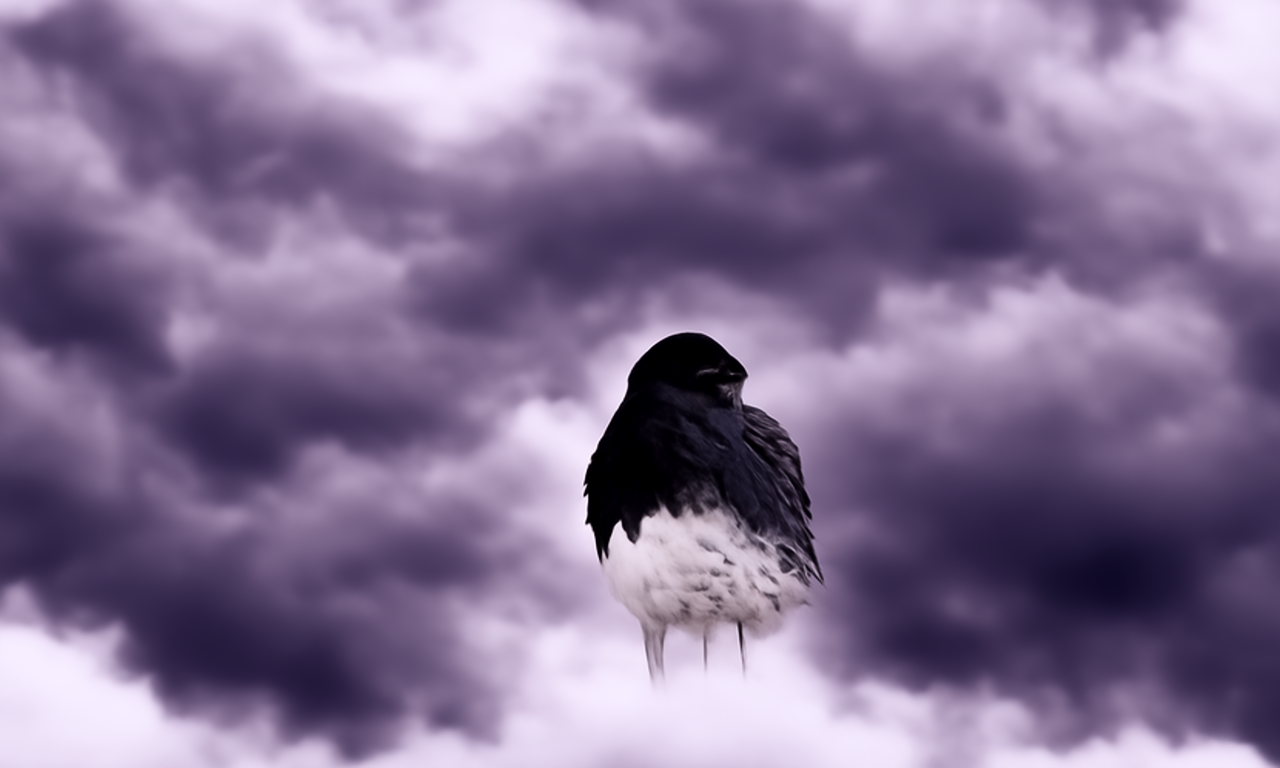

In [ ]:
# @title Do the Run!
# @markdown `n_batches` ignored with animation modes.
display_rate = 20  # @param{type: 'number'}
n_batches = 50  # @param{type: 'number'}

if animation_mode == "Video Input":
    steps = video_init_steps

# Update Model Settings
timestep_respacing = f"ddim{steps}"
diffusion_steps = (1000 // steps) * steps if steps < 1000 else steps
model_config.update(
    {
        "timestep_respacing": timestep_respacing,
        "diffusion_steps": diffusion_steps,
    }
)

batch_size = 1


def move_files(start_num, end_num, old_folder, new_folder):
    for i in range(start_num, end_num):
        old_file = old_folder + f"/{batch_name}({batchNum})_{i:04}.png"
        new_file = new_folder + f"/{batch_name}({batchNum})_{i:04}.png"
        os.rename(old_file, new_file)


# @markdown ---


resume_run = False  # @param{type: 'boolean'}
run_to_resume = "latest"  # @param{type: 'string'}
resume_from_frame = "latest"  # @param{type: 'string'}
retain_overwritten_frames = False  # @param{type: 'boolean'}
if retain_overwritten_frames:
    retainFolder = f"{batchFolder}/retained"
    createPath(retainFolder)


skip_step_ratio = int(frames_skip_steps.rstrip("%")) / 100
calc_frames_skip_steps = math.floor(steps * skip_step_ratio)

if animation_mode == "Video Input":
    frames = sorted(glob(in_path + "/*.*"))
    if len(frames) == 0:
        sys.exit(
            "ERROR: 0 frames found.\nPlease check your video input path and rerun the video settings cell."
        )
    flows = glob(flo_folder + "/*.*")
    if (len(flows) == 0) and video_init_flow_warp:
        sys.exit("ERROR: 0 flow files found.\nPlease rerun the flow generation cell.")

if steps <= calc_frames_skip_steps:
    sys.exit("ERROR: You can't skip more steps than your total steps")

if resume_run:
    if run_to_resume == "latest":
        try:
            batchNum
        except:
            batchNum = len(glob(f"{batchFolder}/{batch_name}(*)_settings.txt")) - 1
    else:
        batchNum = int(run_to_resume)
    if resume_from_frame == "latest":
        start_frame = len(glob(batchFolder + f"/{batch_name}({batchNum})_*.png"))
        if (
            animation_mode != "3D"
            and turbo_mode == True
            and start_frame > turbo_preroll
            and start_frame % int(turbo_steps) != 0
        ):
            start_frame = start_frame - (start_frame % int(turbo_steps))
    else:
        start_frame = int(resume_from_frame) + 1
        if (
            animation_mode != "3D"
            and turbo_mode == True
            and start_frame > turbo_preroll
            and start_frame % int(turbo_steps) != 0
        ):
            start_frame = start_frame - (start_frame % int(turbo_steps))
        if retain_overwritten_frames is True:
            existing_frames = len(
                glob(batchFolder + f"/{batch_name}({batchNum})_*.png")
            )
            frames_to_save = existing_frames - start_frame
            print(f"Moving {frames_to_save} frames to the Retained folder")
            move_files(start_frame, existing_frames, batchFolder, retainFolder)
else:
    start_frame = 0
    batchNum = len(glob(batchFolder + "/*.txt"))
    while os.path.isfile(
        f"{batchFolder}/{batch_name}({batchNum})_settings.txt"
    ) or os.path.isfile(f"{batchFolder}/{batch_name}-{batchNum}_settings.txt"):
        batchNum += 1

print(f"Starting Run: {batch_name}({batchNum}) at frame {start_frame}")

if set_seed == "random_seed":
    random.seed()
    seed = random.randint(0, 2 ** 32)
    # print(f'Using seed: {seed}')
else:
    seed = int(set_seed)

args = {
    "batchNum": batchNum,
    "prompts_series": split_prompts(text_prompts) if text_prompts else None,
    "image_prompts_series": split_prompts(image_prompts) if image_prompts else None,
    "seed": seed,
    "display_rate": display_rate,
    "n_batches": n_batches if animation_mode == "None" else 1,
    "batch_size": batch_size,
    "batch_name": batch_name,
    "steps": steps,
    "diffusion_sampling_mode": diffusion_sampling_mode,
    "width_height": width_height,
    "clip_guidance_scale": clip_guidance_scale,
    "tv_scale": tv_scale,
    "range_scale": range_scale,
    "sat_scale": sat_scale,
    "cutn_batches": cutn_batches,
    "init_image": init_image,
    "init_scale": init_scale,
    "skip_steps": skip_steps,
    "side_x": side_x,
    "side_y": side_y,
    "timestep_respacing": timestep_respacing,
    "diffusion_steps": diffusion_steps,
    "animation_mode": animation_mode,
    "video_init_path": video_init_path,
    "extract_nth_frame": extract_nth_frame,
    "video_init_seed_continuity": video_init_seed_continuity,
    "key_frames": key_frames,
    "max_frames": max_frames if animation_mode != "None" else 1,
    "interp_spline": interp_spline,
    "start_frame": start_frame,
    "angle": angle,
    "zoom": zoom,
    "translation_x": translation_x,
    "translation_y": translation_y,
    "translation_z": translation_z,
    "rotation_3d_x": rotation_3d_x,
    "rotation_3d_y": rotation_3d_y,
    "rotation_3d_z": rotation_3d_z,
    "midas_depth_model": midas_depth_model,
    "midas_weight": midas_weight,
    "near_plane": near_plane,
    "far_plane": far_plane,
    "fov": fov,
    "padding_mode": padding_mode,
    "sampling_mode": sampling_mode,
    "angle_series": angle_series,
    "zoom_series": zoom_series,
    "translation_x_series": translation_x_series,
    "translation_y_series": translation_y_series,
    "translation_z_series": translation_z_series,
    "rotation_3d_x_series": rotation_3d_x_series,
    "rotation_3d_y_series": rotation_3d_y_series,
    "rotation_3d_z_series": rotation_3d_z_series,
    "frames_scale": frames_scale,
    "skip_step_ratio": skip_step_ratio,
    "calc_frames_skip_steps": calc_frames_skip_steps,
    "text_prompts": text_prompts,
    "image_prompts": image_prompts,
    "cut_overview": eval(cut_overview),
    "cut_innercut": eval(cut_innercut),
    "cut_ic_pow": cut_ic_pow,
    "cut_icgray_p": eval(cut_icgray_p),
    "intermediate_saves": intermediate_saves,
    "intermediates_in_subfolder": intermediates_in_subfolder,
    "steps_per_checkpoint": steps_per_checkpoint,
    "perlin_init": perlin_init,
    "perlin_mode": perlin_mode,
    "set_seed": set_seed,
    "eta": eta,
    "clamp_grad": clamp_grad,
    "clamp_max": clamp_max,
    "skip_augs": skip_augs,
    "randomize_class": randomize_class,
    "clip_denoised": clip_denoised,
    "fuzzy_prompt": fuzzy_prompt,
    "rand_mag": rand_mag,
    "turbo_mode": turbo_mode,
    "turbo_steps": turbo_steps,
    "turbo_preroll": turbo_preroll,
    "use_vertical_symmetry": use_vertical_symmetry,
    "use_horizontal_symmetry": use_horizontal_symmetry,
    "transformation_percent": transformation_percent,
    # video init settings
    "video_init_steps": video_init_steps,
    "video_init_clip_guidance_scale": video_init_clip_guidance_scale,
    "video_init_tv_scale": video_init_tv_scale,
    "video_init_range_scale": video_init_range_scale,
    "video_init_sat_scale": video_init_sat_scale,
    "video_init_cutn_batches": video_init_cutn_batches,
    "video_init_skip_steps": video_init_skip_steps,
    "video_init_frames_scale": video_init_frames_scale,
    "video_init_frames_skip_steps": video_init_frames_skip_steps,
    # warp settings
    "video_init_flow_warp": video_init_flow_warp,
    "video_init_flow_blend": video_init_flow_blend,
    "video_init_check_consistency": video_init_check_consistency,
    "video_init_blend_mode": video_init_blend_mode,
}

if animation_mode == "Video Input":
    # This isn't great in terms of what will get saved to the settings.. but it should work.
    args["steps"] = args["video_init_steps"]
    args["clip_guidance_scale"] = args["video_init_clip_guidance_scale"]
    args["tv_scale"] = args["video_init_tv_scale"]
    args["range_scale"] = args["video_init_range_scale"]
    args["sat_scale"] = args["video_init_sat_scale"]
    args["cutn_batches"] = args["video_init_cutn_batches"]
    args["skip_steps"] = args["video_init_skip_steps"]
    args["frames_scale"] = args["video_init_frames_scale"]
    args["frames_skip_steps"] = args["video_init_frames_skip_steps"]

args = SimpleNamespace(**args)

print("Prepping model...")
model, diffusion = create_model_and_diffusion(**model_config)
if diffusion_model == "custom":
    model.load_state_dict(torch.load(custom_path, map_location="cpu"))
else:
    model.load_state_dict(
        torch.load(f"{model_path}/{diffusion_model}.pt", map_location="cpu")
    )
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if "qkv" in name or "norm" in name or "proj" in name:
        param.requires_grad_()
if model_config["use_fp16"]:
    model.convert_to_fp16()

gc.collect()
torch.cuda.empty_cache()
try:
    do_run()
except KeyboardInterrupt:
    pass
finally:
    print("Seed used:", seed)
    gc.collect()
    torch.cuda.empty_cache()

# 5. Create the video

In [ ]:
import PIL

# @title ### **Create video**
# @markdown Video file will save in the same folder as your images.
from tqdm.notebook import trange

skip_video_for_run_all = False  # @param {type: 'boolean'}

if animation_mode == "Video Input":
    frames = sorted(glob(in_path + "/*.*"))
    if len(frames) == 0:
        sys.exit(
            "ERROR: 0 frames found.\nPlease check your video input path and rerun the video settings cell."
        )
    flows = glob(flo_folder + "/*.*")
    if (len(flows) == 0) and video_init_flow_warp:
        sys.exit("ERROR: 0 flow files found.\nPlease rerun the flow generation cell.")

if (video_init_blend_mode == "optical flow") and (animation_mode != "Video Input"):
    print(
        "Please enable Video Input mode and generate optical flow maps to use optical flow video_init_blend_mode"
    )
blend = 0.5  # @param {type: 'number'}
video_init_check_consistency = False  # @param {type: 'boolean'}
if skip_video_for_run_all == True:
    print(
        "Skipping video creation, uncheck skip_video_for_run_all if you want to run it"
    )

else:
    # import subprocess in case this cell is run without the above cells
    import subprocess
    from base64 import b64encode

    latest_run = batchNum

    folder = batch_name  # @param
    run = latest_run  # @param
    final_frame = "final_frame"

    init_frame = (
        1  # @param {type:"number"} This is the frame where the video will start
    )
    last_frame = final_frame  # @param {type:"number"} You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.
    fps = 12  # @param {type:"number"}
    # view_video_in_cell = True #@param {type: 'boolean'}

    frames = []
    # tqdm.write('Generating video...')

    if last_frame == "final_frame":
        last_frame = len(glob(batchFolder + f"/{folder}({run})_*.png"))
        print(f"Total frames: {last_frame}")

    image_path = f"{outDirPath}/{folder}/{folder}({run})_%04d.png"
    filepath = f"{outDirPath}/{folder}/{folder}({run}).mp4"

    if (video_init_blend_mode == "optical flow") and (animation_mode == "Video Input"):
        image_path = f"{outDirPath}/{folder}/flow/{folder}({run})_%04d.png"
        filepath = f"{outDirPath}/{folder}/{folder}({run})_flow.mp4"
        if last_frame == "final_frame":
            last_frame = len(glob(batchFolder + f"/flow/{folder}({run})_*.png"))
        flo_out = batchFolder + f"/flow"
        createPath(flo_out)
        frames_in = sorted(glob(batchFolder + f"/{folder}({run})_*.png"))
        shutil.copy(frames_in[0], flo_out)
        print(sub_p_res)
        for i in trange(init_frame, min(len(frames_in), last_frame)):
            frame1_path = frames_in[i - 1]
            frame2_path = frames_in[i]

            frame1 = PIL.Image.open(frame1_path)
            frame2 = PIL.Image.open(frame2_path)
            frame1_stem = (
                f"{(int(frame1_path.split('/')[-1].split('_')[-1][:-4])+1):04}.jpg"
            )
            flo_path = f"/{flo_folder}/{frame1_stem}.npy"
            weights_path = None
            if video_init_check_consistency:
                # TBD
                pass
            warp(frame1, frame2, flo_path, blend=blend, weights_path=weights_path).save(
                batchFolder + f"/flow/{folder}({run})_{i:04}.png"
            )
    if video_init_blend_mode == "linear":
        image_path = f"{outDirPath}/{folder}/blend/{folder}({run})_%04d.png"
        filepath = f"{outDirPath}/{folder}/{folder}({run})_blend.mp4"
        if last_frame == "final_frame":
            last_frame = len(glob(batchFolder + f"/blend/{folder}({run})_*.png"))
        blend_out = batchFolder + f"/blend"
        createPath(blend_out)
        frames_in = glob(batchFolder + f"/{folder}({run})_*.png")
        shutil.copy(frames_in[0], blend_out)
        for i in trange(1, len(frames_in)):
            frame1_path = frames_in[i - 1]
            frame2_path = frames_in[i]

            frame1 = PIL.Image.open(frame1_path)
            frame2 = PIL.Image.open(frame2_path)

            frame = PIL.Image.fromarray(
                (np.array(frame1) * (1 - blend) + np.array(frame2) * (blend)).astype(
                    "uint8"
                )
            ).save(batchFolder + f"/blend/{folder}({run})_{i:04}.png")

    cmd = [
        "ffmpeg",
        "-y",
        "-vcodec",
        "png",
        "-r",
        str(fps),
        "-start_number",
        str(init_frame),
        "-i",
        image_path,
        "-frames:v",
        str(last_frame + 1),
        "-c:v",
        "libx264",
        "-vf",
        f"fps={fps}",
        "-pix_fmt",
        "yuv420p",
        "-crf",
        "17",
        "-preset",
        "veryslow",
        filepath,
    ]

    process = subprocess.Popen(
        cmd, cwd=f"{batchFolder}", stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate()
    if process.returncode != 0:
        print(stderr)
        raise RuntimeError(stderr)
    else:
        print("The video is ready and saved to the images folder")

    # if view_video_in_cell:
    #     mp4 = open(filepath,'rb').read()
    #     data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    #     display.HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')